# DSCI 571 Lecture 5: Introduction to Linear Classifiers 


UBC Master of Data Science program, 2019-20

Instructor: Varada Kolhatkar [ʋəɾəda kɔːlɦəʈkər]

In [1]:
# Lecture 1
from sklearn.tree import DecisionTreeClassifier

# Lecture 2
from sklearn.model_selection import train_test_split 

# Lecture 3
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from statsmodels.nonparametric.smoothers_lowess import lowess

# Lecture 4
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.preprocessing import normalize, scale, Normalizer, StandardScaler

# Lecture 5
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC, SVR, LinearSVC

# Other
import numpy as np
import pandas as pd
import pickle 

from sklearn import datasets

# pip install git+git://github.com/mgelbart/plot-classifier.git
from plot_classifier import plot_classifier

import matplotlib.pyplot as plt
%matplotlib inline



import pandas as pd
pd.set_option("display.max_colwidth", 200)

import altair as alt

# pip install ipython-autotime
import autotime

# alt.renderers.enable('notebook')
#alt.data_transformers.enable('json')

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [23]:
type(y_train)

numpy.ndarray

In [24]:
def show_scores(model, 
                X_train, y_train,
                X_valid, y_valid):
    """
    Shows train and test error 
    Parameters
    ----------
    model: sklearn classifier model
        The sklearn model
    X_train: numpy.ndarray        
        The X part of the train set
    y_train: numpy.ndarray
        The y part of the train set    
    X_valid: numpy.ndarray        
        The X part of the validation set
    y_valid: numpy.ndarray
        The y part of the validation set    
    Returns
    -------
        None
        prints the train and validation errors. 
            
    """    
    print("Training error:   %.2f" % (1-model.score(X_train, y_train)))
    print("Validation error: %.2f" % (1-model.score(X_valid, y_valid)))

#### What have you done so far?


- Supervised vs. unsupervised
- Classification vs. regression
- Train, test, validation, cross-validation, golden rule
- Overfitting/Underfitting (Variance/Bias)
- Standardization, normalization, OHE
- Models: Decision tree, kNNs, naive Bayes 

####  Quick recap: Bias/variance exercise 

overfitting: low bias but high variance

underfitting: high bias, low variance

high variance: big gap between train/test error

high bias: underfit, high error, small gap

#### Quick recap: Classifiers we have seen so far

- Decision trees: only a small number of features are used to make decisions
- $k$NNs: all features are used equally  
- naive Bayes: Overly strong conditional independence assumption and overestimates the evidence when there are correlated features. 
    
#####  Want
- Can we use most of the features but some more than others?
- Can we build a robust classifier when there are correlated features? 
    - Linear classifiers (today's topic)

#### Today: Learning objectives

From this lecture, students are expected to be able to: 

- Explain the general intuition behind linear classifiers
- Specify weights and biases by hand to represent simple linearly separable functions
- Use `scikit-learn`'s `LogisticRegression` classifier
    - Use `fit`, `predict`, `predict_proba`   
    - Use `coef_` to interpret the model weights 
- Compare logistic regression with naive Bayes     
- Explain the advantages and limitations of linear classifiers 

In this lesson, we focus on binary classification: predicting a binary-valued target. In the next lesson, we'll see how can we extend this to multi-class classification. 

#### Intuition behind a linear classifier

- Learn coefficients (weights) associated with different features

<img src='./img/words_coeff.png' width="300" height="300" />

- Use these learned coefficients to make predictions. For example, consider the following review $x_i$. 
<blockquote> 
    <p>It got a bit <b>boring</b> at times but the direction was <b>excellent</b> and the acting was <b>flawless</b>. </p> 
</blockquote>

- $score(x_i) = $ coefficient(*boring*) + coefficient(*excellent*) + coefficient(*flawless*) = $-1.40 + 1.93 + 1.43 = 1.96$
- Since $score(x_i) = 1.96 > 0$, predict the review as positive 👍. 


#### Linear model 

- $score(x_i) = $ coefficient(*boring*) + coefficient(*excellent*) + coefficient(*flawless*) = $-1.40 + 1.93 + 1.43 = 1.96$
- Since $score(x_i) = 1.96 > 0$, predict the review as positive 👍. 
- Components of a linear model
    - input features ($x_1, \dots, x_d$)
    - coefficients (weights) ($w_1, \dots, w_d$)
    - bias ($b$ or $w_0$)
    - threshold ($r$)
- Linear model is a linear function of $x$, followed by a threshold: 

\begin{equation}
\begin{split}
z =& w_1x_1 + \dots w_dx_d + b\\
=& w^Tx + b
\end{split}
\end{equation}

<center>    
$\hat{y} = \begin{cases}
         1, & \text{if } z \geq r\\
         0, & \text{if } z < r
\end{cases}$
</center>


#### Linear model 

- Linear model is a linear function of $x$, followed by a threshold: $z = w^Tx + b$

<center>
$\hat{y} = \begin{cases}
         1, & \text{if } z \geq r\\
         0, & \text{if } z < r
\end{cases}$
</center>

- We can simplify the model by 
    - Eliminating the threshold by replacing ($b-r$) by $b'$. 
    - Eliminating bias by introducing a dummy feature $x_0$ whose value is always 1 and the weight $w_0$ is the bias. 
- The simplified model is: $z = w^Tx$ 

<center>
$\hat{y} = \begin{cases}
         1, & \text{if } z \geq 0\\
         0, & \text{if } z < 0
\end{cases}$
</center>



#### Linear model you have seen before
- Linear regression model: the output is a weighted sum of the inputs (this is `predict`)
- Least squares: we try to minimize the squared deviation between our predictions and our `y_train` (this is `fit`)

#### Linear regression notation in Statistics vs. ML 
- DSCI 561 / Stats 
    - coefficients, $\alpha$ or $\beta_i$
    - intercept, $\beta_0$   
    - $y = \beta_1x_1 + \beta_2x_2 + \ldots + \beta_dx_d + \beta_0 + \varepsilon$    
    
- DSCI 571 / CPSC 340 / ML
    - weights, $w_j$
    - intercept or _bias_, $w_0$ or $\beta$ (sigh...)
    - $\hat{y} = w_1x_1 + w_2x_2 + \ldots + w_dx_d + w_0$

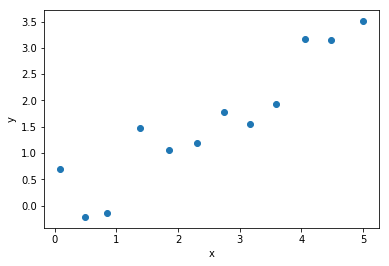

In [4]:
n = 12
d = 2

x = np.linspace(0,5,n)  + np.random.randn(n)*0.05
y = x*0.7 + np.random.randn(n)*0.5
X = x[:,None]

plt.scatter(x,y)
plt.xlabel('x')
plt.ylabel('y');

In [5]:
def make_plot(lr, x, y):
    grid = np.linspace(np.min(x)-0.3,np.max(x)+.3,1000)[:,None]

    plt.scatter(x, y, label="training data")
    plt.xlabel('x')
    plt.ylabel('y');
    plt.plot(grid, lr.predict(grid), 'black', label="model")
    
    yhat = lr.predict(x[:,None])
#     plt.scatter(x, yhat, label="training predictions")
    for i in range(len(y)):
        if i == 0:
            plt.plot((x[i],x[i]),(y[i],yhat[i]), 'red', label="residuals")
        else:
            plt.plot((x[i],x[i]),(y[i],yhat[i]), 'red')

    plt.legend(fontsize=12)    

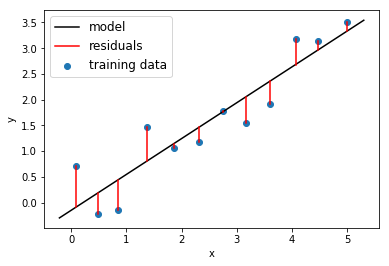

In [6]:
lr = LinearRegression()
lr.fit(X, y);
make_plot(lr, x, y)

In [7]:
lr.coef_

array([0.69596532])

In [8]:
lr.intercept_

-0.14729197334329358

### Linear regression vs. linear classifiers

Linear regression is _not_ fitting a line, it's fitting a $d$-dimensional hyperplane.  
$$\hat{y} = w^Tx + w_0$$

regression, y hat is weighted sum

Linear classifier: $$\hat{y} = \text{sign}(w^Tx + w_0)$$  

- In $d+1$ dimensional space, the decision boundary of a linear classifier is a $d$-dimensional hyperplane. For example: 
    - in two dimensions, a 1-d hyperplane is simply a line. 
    - in three dimensions, a 2-d hyperplane is like a sheet of paper.

#### Vectorization

- Linear classifier: $$\hat{y} = w_1x_1 + w_2x_2 + \ldots + w_dx_d + w_0$$
Or like this:$$\hat{y} = w_0 + \sum_{j=1}^dw_jx_j$$

- How will you write a loop in Python to do this? 


```
y_hat = w_0
for i in range(d):
    y_hat +=  w[i] * x[i]

```

In [9]:
import random
d = 100000
w_0 = np.random.rand(1)[0]
w = np.random.rand(d) 
x = np.random.randint(2, size=d)

In [10]:
%%time
## Linear classifier with a python loop 

y_hat = w_0
for i in range(d):
    y_hat +=  w[i] * x[i]

CPU times: user 81.4 ms, sys: 3.8 ms, total: 85.2 ms
Wall time: 81.4 ms


#### Vectorization

- Loops in Python are slow so we vectorize it and solve it using `numpy` matrices, which is much faster.  

<center>
$$\hat{y} = \begin{bmatrix}w_1 & w_2 & \cdots & w_d\end{bmatrix}\begin{bmatrix}x_1 \\ x_2 \\ \vdots \\ x_d\end{bmatrix} + w_0$$


```
y_hat = np.dot(w,x) + w_0
```
</center>


In [11]:
%%time
# Linear classifier with vectorization 
y_hat = np.dot(w,x) + w_0

CPU times: user 1.19 ms, sys: 1.55 ms, total: 2.75 ms
Wall time: 2.64 ms


#### Vectorization  (one step further)

- Organize all the training examples into a matrix $X$ with one row per training example, and all the targets
into a vector $t$. 
- For example $X$ for `and` function will be: 

$$X = \begin{bmatrix}x_1^T\\ x_2^T \\ x_3^T\\ x_4^T\end{bmatrix} = \begin{bmatrix} 0 & 0\\ 0 & 1\\ 1 & 0\\ 1 & 1\end{bmatrix}$$ 

- Compute the predictions for the whole dataset 
$$Xw + b1 = \begin{bmatrix} w_1^Tx_1\\w_2^Tx_1\\\cdots\\ w_n^Tx_n\end{bmatrix} = \begin{bmatrix} \hat{y_1}\\\hat{y_2}\\\cdots\\ \hat{y_n}\end{bmatrix}$$ 

### Break (~5 mins)

#### Linear classifiers we are going to focus on

- Logistic regression (this lesson) 
    - `sklearn.linear_model.LogisticRegression`
- Support vector machines (next lesson)
    - `sklearn.svm.SVC`
    - `sklearn.svm.LinearSVC`

### Logistic regression 
- Probabilistic linear classifier 
- Components of a probabilistic machine learning classifier 
    1. Data: A feature representation of the input
    2. A classification function that computes $\hat{y}$
    4. Loss function: e.g., squared error (572, 573)
    5. Optimization algorithm: e.g., gradient descent (572)

In this course we focus on 1. and 2.   

#### Logistic regression

In particular, we will focus on 
- use `fit`, `predict`, `predict_proba`
- use `coef_` to interpret the model weights 
- compare logistic regression with naive Bayes

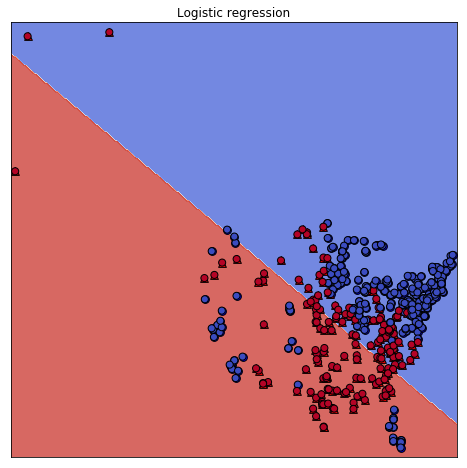

In [13]:

## `fit` a LogisticRegression classifier on a . slightly modified US_cities dataset
with open("data/citiesSmall.pkl", "rb") as f:
    data = pickle.load(f)
X_train = data['X']
y_train = data['y']

X_test = data['Xtest']
y_test = data['ytest']
lr = LogisticRegression()
lr.fit(X_train, y_train);
plt.figure(figsize=(8,8))
plot_classifier(X_train, y_train, lr, ax=plt.gca());
plt.title("Logistic regression");

In [14]:
# Predicting probabilities
# You can look at the probabilities (confidence) of the classifier's prediction using 
# the `model.predict_proba` method
print('y_train: ', y_train[:10])
print('Probabilities: ' )
lr.predict_proba(X_train[:10])

y_train:  [1 1 1 1 1 1 1 0 1 1]
Probabilities: 


array([[0.50425512, 0.49574488],
       [0.1564548 , 0.8435452 ],
       [0.56867187, 0.43132813],
       [0.1598022 , 0.8401978 ],
       [0.56123901, 0.43876099],
       [0.69564481, 0.30435519],
       [0.62544123, 0.37455877],
       [0.81400881, 0.18599119],
       [0.21086659, 0.78913341],
       [0.48430243, 0.51569757]])

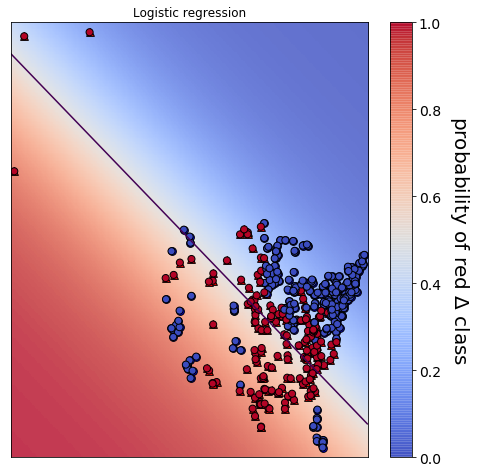

In [15]:
plt.figure(figsize=(8,8))
plot_classifier(X_train, y_train, lr, proba=True, ax=plt.gca());
plt.title("Logistic regression");

#### Let's train it on another dataset

Read IMDB data you used in lab2  

In [16]:
# Read IMDB movie reviews into a pandas DataFrame
imdb_df = pd.read_csv('data/imdb_master.csv', encoding = "ISO-8859-1")
# Only keep the reviews with pos and neg labels
imdb_df = imdb_df[imdb_df['label'].str.startswith(('pos','neg'))]
imdb_df.head(4)

,Unnamed: 0,type,review,label,file
0,0,test,"Once again Mr. Costner has dragged out a movie for far longer than necessary. Aside from the terrific sea rescue sequences, of which there are very few I just did not care about any of the charact...",neg,0_2.txt
1,1,test,"This is an example of why the majority of action films are the same. Generic and boring, there's really nothing worth watching here. A complete waste of the then barely-tapped talents of Ice-T and...",neg,10000_4.txt
2,2,test,"First of all I hate those moronic rappers, who could'nt act if they had a gun pressed against their foreheads. All they do is curse and shoot each other and acting like clichÃ©'e version of gangst...",neg,10001_1.txt
3,3,test,"Not even the Beatles could write songs everyone liked, and although Walter Hill is no mop-top he's second to none when it comes to thought provoking action movies. The nineties came and social pla...",neg,10002_3.txt


#### Feature representation 

- Word counts or tf-idf scores 

In [17]:
from sklearn.linear_model import LogisticRegression
# For converting words into frequency counts
from sklearn.feature_extraction.text import CountVectorizer
X_train_imdb, X_test_imdb, y_train_imdb, y_test_imdb = train_test_split(imdb_df['review'], 
                                                                        imdb_df['label'], 
                                                                        test_size = 0.20, 
                                                                        random_state = 12)

vec = CountVectorizer(max_features=5000,                       
                      stop_words='english')

# "fit" the vectorizer on the training data only*
X_train_counts = vec.fit_transform(X_train_imdb) 

# Only transform on the test data.  
X_test_counts = vec.transform(X_test_imdb) 

#### `fit` and `predict` using `LogisticRegression`

In [18]:
# fit and predict with logistic regression 
lr = LogisticRegression()
lr.fit(X_train_counts, y_train_imdb)
show_scores(lr,X_train_counts, y_train_imdb, X_test_counts, y_test_imdb) 

Training error:   0.06
Validation error: 0.13


In [25]:
def print_review_prediction(index, predicted, prediction_proba):
    """
    Shows reviews and predictions.
    
    Parameters
    ----------
    index: int 
        The index in the test data
    predicted: str
        The predicted class 
    prediction_proba:
        The prediction probability
    
    Returns
    -------
        None
        prints the review at the given index, their true class, predicted class and prediction probability 
            
    """        
    print('Review: ', X_test_imdb.iloc[[index]])
    print('True class: ', y_test_imdb.iloc[index])
    print('Predicted class: ', predicted)
    print('Prediction probability: ', prediction_proba)
    print('\n-----------\n')

#### Predicting probabilities

- Remember that you can look at the probabilities (confidence) of the classifier's prediction using the `model.predict_proba` method
- Can we find the reviews where our classifier is most confident or least confident?
- How about reviews where the classifier is not very confident? 

In [20]:
# predict_proba
lr.predict_proba(X_test_counts)

# What's the most positive and most negative review according to our classifier?  
np.argmax(lr.predict_proba(X_test_counts)[:,1])
most_positive_index = np.argmax(lr.predict_proba(X_test_counts)[:,1])
most_negative_index = np.argmax(lr.predict_proba(X_test_counts)[:,0])

print_review_prediction(most_positive_index, 'pos', lr.predict_proba(X_test_counts)[most_positive_index][1])
print_review_prediction(most_negative_index, 'neg', lr.predict_proba(X_test_counts)[most_negative_index][0])

Review:  13379    I have never been a great fan of Oliver Stone, often because I have found his films to be forced, preachy and generally flawed. The two Stone films I truly like are JFK and Talk Radio, yet Talk Ra...
Name: review, dtype: object
True class:  pos
Predicted class:  pos
Prediction probability:  1.0

-----------

Review:  5252    Plankton, or Creatures from the Abyss as I'm positive it's more commonly known as & filmed under as the title Creatures from the Abyss appears over a moving image & in the same font type as the re...
Name: review, dtype: object
True class:  neg
Predicted class:  neg
Prediction probability:  1.0

-----------



### Interpretability of logistic regression classifier

- One of the primary advantage of linear classifiers is their ability to interpret models. 
- What features are most useful for prediction? 

### Example: Interpretability of linear classifiers

In lab 2, you used Naive Bayes for sentiment classification in IMDB. Suppose you want to find out what the model has learned. In other words, suppose you want to examine the words that are indicative of positive and negative reviews according to the model. 

The information you need is exposed by the weights (coefficients) learned by the mode, which are exposed by [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) object. The vocabulary (mapping from feature indices to actual words) can be obtained using the following. 

#### Let's find the most informative words for positive and negative reviews 

- The information you need is exposed by the `coef_` attribute of [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) object. 
- The vocabulary (mapping from feature indices to actual words) can be obtained as follows: 

In [21]:
# Get features (words in our case)
vocab = vec.get_feature_names()
weights = lr.coef_.flatten()

# Sort the coefficients in descending order 
inds = np.argsort(lr.coef_.flatten())

# pick the first 20 as most informative features for negative reviews  
negative_words = [vocab[index] for index in inds[:20]]

# pick the last 20 features as most informative features for positive reviews  
positive_words = [vocab[index] for index in inds[-20:]]

neg_words_weights = [(weights[index]) for index in inds[:20]]
pos_words_weights = [(weights[index]) for index in inds[-20:]]

df = pd.DataFrame({'Neg feats':negative_words, 'Neg weights':neg_words_weights, 
                   'Pos feats':positive_words, 'Pos weights':pos_words_weights})
df

,Neg feats,Neg weights,Pos feats,Pos weights
0,waste,-2.292755,pleasantly,1.393803
1,disappointment,-2.204200,wonderfully,1.396857
2,mst3k,-2.174482,pitch,1.415232
3,unwatchable,-2.047357,bravo,1.416209
4,uninspired,-2.040188,glorious,1.424288
5,stinker,-2.023423,rupert,1.428020
6,mildly,-1.957676,subtle,1.434285
7,olds,-1.953250,flawless,1.438492
8,disjointed,-1.928560,vengeance,1.442418
9,lousy,-1.924056,astonishing,1.448871


### Question for you to ponder on 

Is it possible to identify most important features using $k$-NNs? What about decision trees and naive Bayes?  

#### Generative vs discriminative models 

- A visual metaphor from [Jurafsky and Martin 2019](https://web.stanford.edu/~jurafsky/slp3/5.pdf): Imagine we are trying to distinguish dog images from cat images. 

- A generative model would have the goal of understanding what dogs look like and what cats look like. You can ask a generative model to draw a dog. During predict, we ask which model fits the given image best. 
- A discriminative model is only trying to learn to distinguish the classes. For instance, if all the dogs in the training data are wearing collars and cats aren't, it would tell you that the difference between cats and dogs is that they do not wear collars. 

<img src='./img/cat.png' width="300" height="300">
<img src='./img/dog.png' width="300" height="300">



#### Naive Bayes vs. Logistic regression 

- Both are probabilistic classifiers but Naive Bayes is "generative" and Logistic regression is "discriminative"
- Naive Bayes is a generative model because it's modeling the joint distribution over the features $x$ and labels $y$. 
- Logistic regression it directly models the probability $p(y|x)$

#### Choosing a classifier: Logistic regression vs. Naive Bayes

- Naive Bayes has overly strong conditional independence assumptions. So not great when features are correlated. 
    - If two features are strongly correlated, Naive Bayes will overestimating the evidence of that feature.
- Logistic regression is much more robust to correlated features
    - If two features are correlated, regression will assign part of the weight to one and part
to another. 
- For smaller datasets Naive Bayes is a good choice. Logistic regression generally works
better on larger datasets and is a common default.
    - See [this](https://papers.nips.cc/paper/2020-on-discriminative-vs-generative-classifiers-a-comparison-of-logistic-regression-and-naive-bayes.pdf) and/or [this](https://www.aclweb.org/anthology/P12-2018.pdf). 
    

#### Limitations of linear classifiers 

- Is your data "linearly separable"? Can you draw a hyperplane between these datapoints that separates them with 0 error. 
    - If the training examples can be separated by a linear decision rule, they are **linearly separable**.

- The `not` and `and` function we saw before is linearly separable. What about the following XOR function?  

| $$x_1$$ | $$x_2$$ | target|
|---------|---------|---------|
| 0 | 0  | 0|
| 0 | 1  | 1|
| 1 | 0  | 1|
| 1 | 1  | 0|    



A few questions you might be thinking about
- How often do you think the real-life data is linearly separable?
- Are linear classifiers very limiting because of this?     
- Can we use logistic regression for multi-class classification?
    -  Yes. See multinomial logistic regression also called **softmax regression** or **the maxent classifier** 

#### Coming up

- Support Vector Machines
    - `fit`, `predict`
    - Support vectors
    - Max margin
    - Hyperparameters
- Milti-class classification    
- Random Forests    

#### Why people use linear classifiers?  

Logistic regression is used EVERYWHERE!

- Fast training and testing.
  - Training on huge datasets.
  - Testing is just computing $w^Tx_i$.
- Weights $w_j$ are easy to understand. 
  - It's how much $x_j$ changes the prediction and in what direction.
- Are somewhat related to neural networks (can be thought of as a 1-layer neural network)
- When I carry out research, logistic regression is the first model I try as a baseline.  

## True/False video review questions (5 mins)

**Linear classifiers** (for binary classification):

1. For linear classifiers, the decision boundary (the boundary dividing the two classes) is a $d-1$-dimensional hyperplane.
2. The coefficients of a linear classifier have a similar interpretation to that of linear regression: if coefficient $j$ is large, that means a change in feature $j$ has a large impact on the prediction.
3. In a linear classifier, decreasing the magnitude of all the coefficients leads to predicted probabilities that are closer to 0.5.


<br><br><br><br><br><br><br><br><br>

# DSCI 571 Lecture 6: Support Vector Machines, Multi-Class Classification, and  Random Forests 


UBC Master of Data Science program, 2019-20

Instructor: Varada Kolhatkar [ʋəɾəda kɔːlɦəʈkər]

In [3]:
# Lecture 1
from sklearn import tree 
from sklearn.tree import DecisionTreeClassifier

# Lecture 2
from sklearn.model_selection import train_test_split 

# Lecture 3
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from statsmodels.nonparametric.smoothers_lowess import lowess

# Lecture 4
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.preprocessing import normalize, scale, Normalizer, StandardScaler

# Lecture 5
from sklearn.linear_model import LogisticRegression, LinearRegression


# Lecture 6
from sklearn.svm import SVC, SVR, LinearSVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.ensemble import RandomForestClassifier

# Other
import numpy as np
import pandas as pd
import pickle 

import graphviz

from sklearn import datasets
from sklearn.datasets import make_blobs

# pip install git+git://github.com/mgelbart/plot-classifier.git
from plot_classifier import plot_classifier

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
pd.set_option("display.max_colwidth", 200)

import altair as alt

# pip install ipython-autotime
import autotime

alt.renderers.enable('notebook')
#alt.data_transformers.enable('json')

## Attribution: Many visualization code snippets are from Mike's lecture from last year. 

RendererRegistry.enable('notebook')

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [9]:
def show_scores(model, 
                X_train, y_train,
                X_valid, y_valid):
    """
    Shows train and test error 
    Parameters
    ----------
    model: sklearn classifier model
        The sklearn model
    X_train: numpy.ndarray        
        The X part of the train set
    y_train: numpy.ndarray
        The y part of the train set    
    X_valid: numpy.ndarray        
        The X part of the validation set
    y_valid: numpy.ndarray
        The y part of the validation set    
    Returns
    -------
        None
        prints the train and validation errors. 
            
    """    
    print('Model: ', model)
    print("Training error:   %.2f" % (1-model.score(X_train, y_train)))
    print("Validation error: %.2f" % (1-model.score(X_valid, y_valid)))
    print('\n\n')

In [10]:
# define a function to plot our model
def save_and_show_decision_tree(model, 
                                class_names,
                                feature_names,
                                save_file_prefix = 'test'):
    """
    Saves the decision tree model as a pdf and shows how the data is split and 
    classified

    Parameters
    ----------
    model: sklearn.tree.DecisionTreeClassifier
        The sklearn model decision tree
    class_names : list
        The names of all the possible classifications
    feature_names : list
        The names of all the features
    save_file_prefix: str
        The name you wish to save the file

    Returns
    -------
    graphviz.files.Source
        The decision tree graph
    """
    dot_data = tree.export_graphviz(model, out_file=None, 
                             feature_names=feature_names,  
                             class_names=class_names,  
                             filled=True, rounded=True,  
                             special_characters=True)  

    graph = graphviz.Source(dot_data) 
    graph.render(save_file_prefix) 
    return graph


#### First of all, are you able to run my notebooks?

If not, please reach out. 

#### A note about the structure of 571

- You might be thinking that we didn't get into the details of how `fit` works for Logistic Regression.
    - This is because we haven't yet built the foundation you need to understand it, which we'll be doing in 572 and 573. 
- 571 is about the inputs and outputs, gaining exposure to a lot of methods.
- 572/573 will cover more about how they work.    
- In 571, the idea is to make you familiar with how to **use** these algorithms.  
- We do this because we have noticed that students are more motivated to learn the theory if they already have used it before. 

#### Lecture plan

- SVMs (~35 mins)
- Break (~5 mins)
- Multiclass-classification (~15 mins)
- Random Forests (~15 mins)
- Summary and wrap-up (~5 mins)

#### Today: Learning outcomes

From this lecture, students are expected to be able to: 

- Use `scikit-learn`'s `SVC` classifier
- Explain the concept of support vectors    
- Use $C$ and $\gamma$ hyperparameters of SVMs and explain how they relate to the fundamental trade-off.
- Carry out multi-class classification using OVR and OVO
- Explain randomness in random forest algorithm
- Use `scikit-learn`'s `RandomForestClassifier`

### SVM motivation: Which decision boundary is better? 

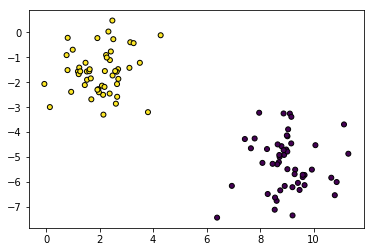

In [6]:
# Let's generate some fake data

# generate blobs with fixed random generator
n_classes = 2
X_lin_sep, y_lin_sep = make_blobs(n_features=2, centers=n_classes, random_state=200)

# How does the data look like? 
plt.scatter(X_lin_sep[:, 0], X_lin_sep[:, 1], marker='o', c=y_lin_sep, s=25, edgecolor='k')

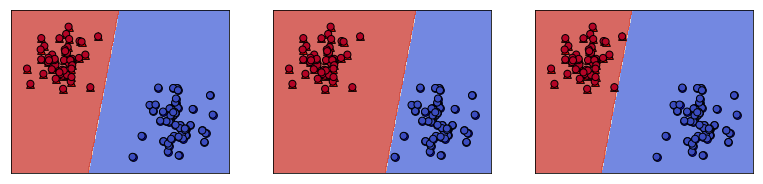

In [58]:
# Which hyperplane to choose? 
lr = LogisticRegression()
lr.fit(X_lin_sep, y_lin_sep);
intercepts = [lr.intercept_, lr.intercept_ + 1.6, lr.intercept_ -0.5]
plt.figure(figsize=(18,3))
for i in range(3):
    plt.subplot(1,4,i+1)
    lr.intercept_ = intercepts[i]
    plot_classifier(X_lin_sep,y_lin_sep,lr,ax=plt.gca())

#### SVMs: General idea

- Choose the hyperplane which is furthest away from the closest training points. 
- In other words, choose the hyperplane which has the largest **margin**, where margin is the distance from the boundary to the nearest point(s).
- Intuitively, more margin is good because it leaves more "room" before we make an error.
- This happens in `fit`. In this course, we won't go in details of how this is done exactly (more on this in 573).

<img src='./img/SVM_margin.png' width="500" height="500">        

[Image Source](https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html?highlight=svm%20margin)



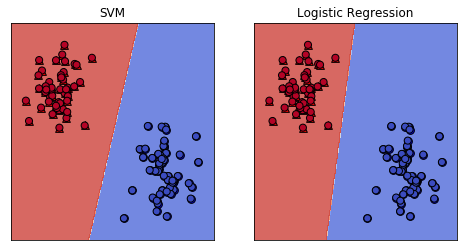

In [8]:
# Let's train an SVM classifier. 
# It picks the hyperplane than maximizes the margin. 
# Seems like logistic regression isn't doing it. 

svm = SVC(kernel="linear", C=1e6) # ignore the C=1e6 for now
svm.fit(X_lin_sep, y_lin_sep)

lr = LogisticRegression()
lr.fit(X_lin_sep, y_lin_sep);

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title("SVM")
plot_classifier(X_lin_sep, y_lin_sep, svm, ax=plt.gca())
plt.subplot(1,2,2)
plt.title("Logistic Regression");
plot_classifier(X_lin_sep, y_lin_sep, lr, ax=plt.gca())

In [9]:
def SV_proj(svm):
    v = svm.support_vectors_
    s = np.array([svm.coef_.flatten()[1], -svm.coef_.flatten()[0]])
    w = svm.coef_
    return (v@s[:,None])/(s@s) * s - w/(w@w.T)*svm.intercept_

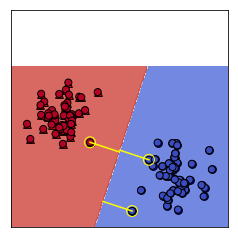

In [10]:
plt.figure(figsize=(4,4))
plot_classifier(X_lin_sep, y_lin_sep, svm, ax=plt.gca());
plt.scatter(*svm.support_vectors_.T, marker="o", edgecolor="yellow", facecolor="none", s=120);
plt.axis('equal');
plt.axis('square');

proj = SV_proj(svm)

for i in range(len(proj)):
    p = proj[i]
    sv = svm.support_vectors_[i]
    plt.plot((p[0],sv[0]),(p[1],sv[1]), 'yellow')

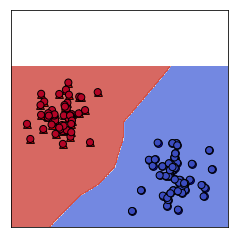

In [11]:
# (Bonus) This is kind of similar to KNN with $k=1$, 
# since the boundary will always be half way between examples of different labels:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_lin_sep, y_lin_sep)
plt.figure();
plot_classifier(X_lin_sep, y_lin_sep, knn, ax=plt.gca());
plt.axis('equal');
plt.axis('square');

#### Support vectors 

- Each training example either is or isn't a "support vector".
  - This gets decided during `fit`.
  - It does not apply to test examples.

- **Main idea: the decision boundary only depends on the support vectors.**

- Let's look at the support vectors 

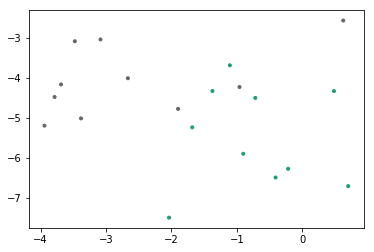

In [60]:
# How to `fit` an SVM classifier with sklearn? 

# Let's generate some fake data

# generate blobs with fixed random generator
n = 20
n_classes = 2
X, y = make_blobs(n_samples=n, centers=n_classes, random_state=300)

# How does the data look like? 
plt.scatter(*X.T, c=y, marker='.', cmap='Dark2');

In [61]:
# Let's train an SVM classifier
svm = SVC(kernel="linear", C=1e6) # ignore the C=1e6 for now
svm.fit(X,y)

# How do we access support vectors
sv = svm.support_
not_sv = list(set(range(n)) - set(sv))
print('Support vectors: ', sv)
print('Non support vectors: ', not_sv)

Support vectors:  [ 3  8 14 19  0  1  6 17]
Non support vectors:  [2, 4, 5, 7, 9, 10, 11, 12, 13, 15, 16, 18]


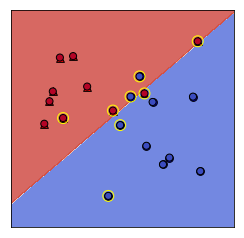

In [62]:
plt.figure(figsize=(4,4))
plot_classifier(X,y,svm, ax=plt.gca())
plt.scatter(*svm.support_vectors_.T, marker="o", edgecolor="yellow", facecolor="none", s=120);

# The support vectors (SVs) are shown in yellow.
# These are the example that "support" the boundary. 

#### Support vectors

- Note that the number of support vectors is much smaller compared to the training set. 
- What happens if we delete all non-support vector? Would the decision boundary change? 
- What happens if we delete a support vector? Would the decision boundary change? 

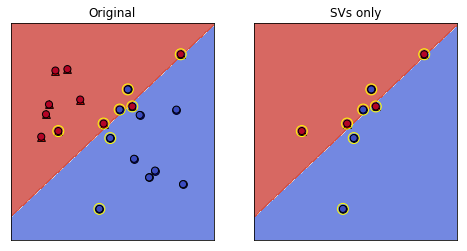

In [63]:
# Let's try removing all other examples, keeping only the SVs.
# remove all non-support vectors
X_only_SVs = np.delete(X,not_sv,0)
y_only_SVs = np.delete(y,not_sv,0)

svm_only_SVs = SVC(kernel="linear", C=1e6)
svm_only_SVs.fit(X_only_SVs, y_only_SVs)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plot_classifier(X,y,svm, ax=plt.gca())
plt.scatter(*svm.support_vectors_.T, marker="o", edgecolor="yellow", facecolor="none", s=120);
plt.title("Original");
plt.subplot(1,2,2)
plot_classifier(X_only_SVs, y_only_SVs, svm_only_SVs, ax=plt.gca(), 
                lims=(X[:,0].min()-1,X[:,0].max()+1,X[:,1].min()-1,X[:,1].max()+1))
plt.scatter(*svm_only_SVs.support_vectors_.T, marker="o", edgecolor="yellow", facecolor="none", s=120);
plt.title("SVs only");


In [16]:
# Are the learned weights different? 
print(svm.coef_)
print(svm_only_SVs.coef_)
print("The coefficients are the same!")

assert np.allclose(svm.coef_, svm_only_SVs.coef_) == True, "Expected to be equal"

# Why not use `np.array_equal` here?
# It isn’t recommended for numerical procedures because 
# even the slightest roundoff error can make them not equal.
#assert np.array_equal(svm.coef_, svm_only_SVs.coef_) == True, "Expected to be equal"

[[-1.54440392  1.68092276]]
[[-1.54440393  1.68092276]]
The coefficients are the same!


In [17]:
# remove a support vector
X_remove_SV = np.delete(X,sv[1],0)
y_remove_SV = np.delete(y,sv[1],0)

svm_remove_SV = SVC(kernel="linear", C=1e6)
svm_remove_SV.fit(X_remove_SV, y_remove_SV);
print(svm.coef_)
print(svm_remove_SV.coef_)
assert np.allclose(svm.coef_, svm_remove_SV.coef_) == False, "Expected to be unequal"

[[-1.54440392  1.68092276]]
[[-2.04058608  4.89791658]]


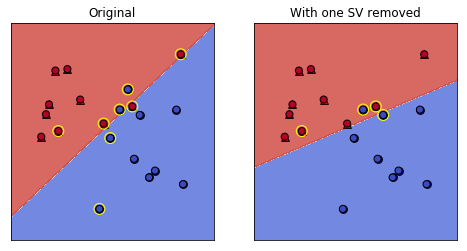

In [18]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plot_classifier(X,y,svm, ax=plt.gca())
plt.scatter(*svm.support_vectors_.T, marker="o", edgecolor="yellow", facecolor="none", s=120);
plt.title("Original");

plt.subplot(1,2,2)
plot_classifier(X_remove_SV,y_remove_SV,svm_remove_SV, ax=plt.gca())
plt.scatter(*svm_remove_SV.support_vectors_.T, marker="o", edgecolor="yellow", facecolor="none", s=120);
plt.title("With one SV removed");

### Nonlinear SVM (5 min)

- Do SVMs work only with linearly-separable data?
    - No. We can use the "kernel" trick to deal with non linearly separable surfaces
- We don't go into the details right now (possibly in 573).    
- The general idea is mapping the non-linearly separable data into a higher dimensional space where you can find a separating hyperplane. 
- By default, `SVC` uses the "RBF kernel".
- It's also possible to do kernel logistic regression, but...
  - it's less popular than kernel SVM for computational reasons.
  - it's not implemented in `scikit-learn`.

In [20]:
with open("data/citiesSmall.pkl", "rb") as f:
    data = pickle.load(f)
X_train = data['X']
y_train = data['y']

X_test = data['Xtest']
y_test = data['ytest']

In [21]:
linear_svm = SVC(kernel='linear')
linear_svm.fit(X_train, y_train)
show_scores(linear_svm, X_train, y_train, X_test, y_test)

# By dedault SVC uses rbf kernel 
rbf_svm = SVC()
rbf_svm.fit(X_train, y_train)
show_scores(rbf_svm, X_train, y_train, X_test, y_test)

Model:  SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Training error:   0.27
Validation error: 0.29



Model:  SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Training error:   0.02
Validation error: 0.06





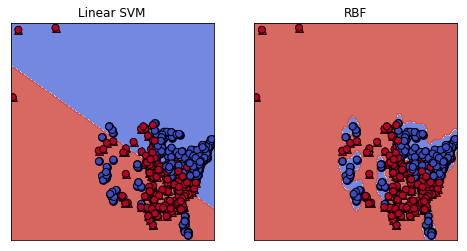

In [22]:
# Plot linear SVM
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plot_classifier(X_train, y_train, linear_svm, ax=plt.gca())
plt.title("Linear SVM");

# Plot RBF SVM
plt.subplot(1,2,2)
plot_classifier(X_train, y_train, rbf_svm, ax=plt.gca())
plt.title("RBF");

<Figure size 288x288 with 0 Axes>

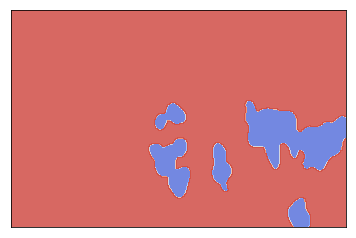

In [23]:
plt.figure(figsize=(4,4))
plot_classifier(X_train, y_train, rbf_svm, show_data=False)

## Hyperparameters

- Key Hyperparameters of `rbf` SVM are
    - `gamma`
    - `C`

See [`scikit-learn`'s explanation of RBF SVM parameters](https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html). 

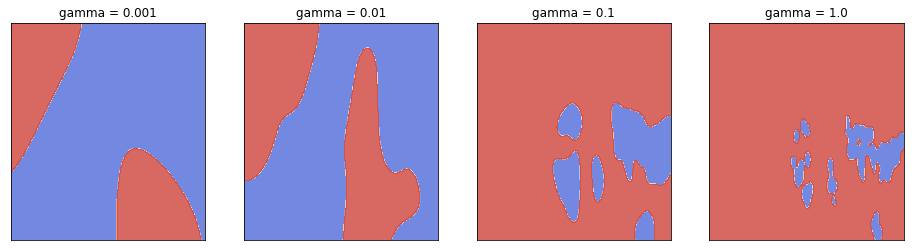

In [24]:
# What's the effect of the gamma parameter? 
plt.figure(figsize=(16,4))
for i in range(4):
    plt.subplot(1,4,i+1)
    gamma = 10.0**(i-3)
    rbf_svm = SVC(gamma=gamma)
    rbf_svm.fit(X_train, y_train);
    plot_classifier(X_train, y_train, rbf_svm, ax=plt.gca(), show_data=False);
    plt.title("gamma = %s"%gamma);

#### What is `gamma` doing?

- Larger `gamma`: more rapid fluctuations in the decision surface (can change from red to blue in a short distance).
- Smaller `gamma` smoother fluctuations. 

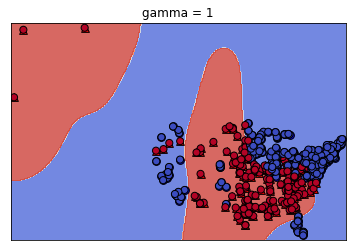

In [25]:
# In a sense, `gamma` (actually square root of `gamma`) is the scaling for the problem. 
# E.g., if we divide all the features by 10, that is like dividing gamma by 100.
mult = 0.1 # multiply all features by this value

rbf_svm = SVC(gamma=1)
rbf_svm.fit(X_train*mult, y_train);
plot_classifier(X_train*mult, y_train, rbf_svm, ax=plt.gca(), 
                lims=(X_train[:,0].min()*mult-mult,X_train[:,0].max()*mult+mult,
                      X_train[:,1].min()*mult-mult,X_train[:,1].max()*mult+mult));
plt.title("gamma = %s"%1);

### Relation of gamma and the fundamental trade-off

- `gamma` controls the complexity (fundamental trade-off), just like other hyperparameters we've seen.
  - larger `gamma` $\rightarrow$ more complex
- `C` _also_ affects the fundamental tradeoff, although in a less intuitive way.
  - larger `C` $\rightarrow$ more complex  

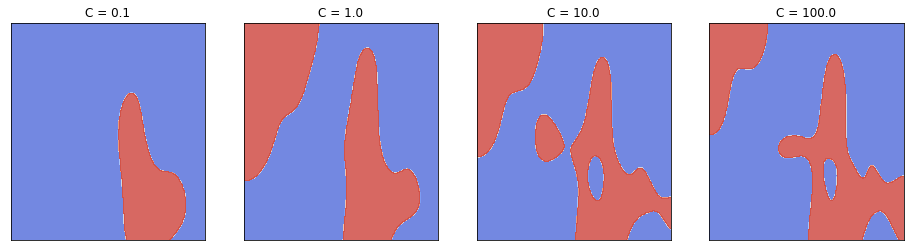

In [26]:
plt.figure(figsize=(16,4))
for i in range(4):
    plt.subplot(1,4,i+1)
    C = 10.0**(i-1)
    rbf_svm = SVC(C=C, gamma=0.01)
    rbf_svm.fit(X_train, y_train);
    plot_classifier(X_train, y_train, rbf_svm, ax=plt.gca(), show_data=False);
    plt.title("C = %s"%C);

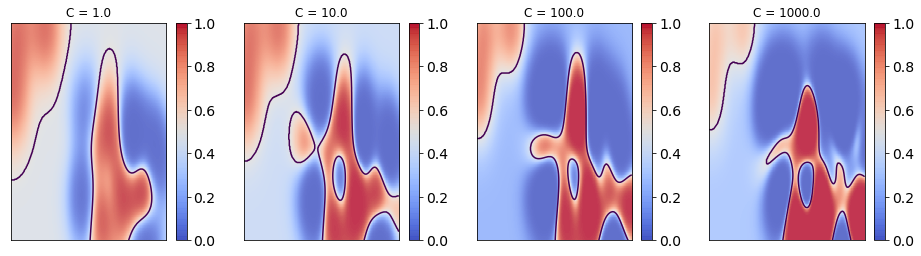

In [27]:
plt.figure(figsize=(16,4))
for i in range(4):
    plt.subplot(1,4,i+1)
    C = 10.0**(i)
    rbf_svm = SVC(C=C, gamma=0.01, probability=True)
    rbf_svm.fit(X_train, y_train);
    plot_classifier(X_train, y_train, rbf_svm, ax=plt.gca(), show_data=False, proba=True, proba_showtitle=False);
    plt.title("C = %s"%C);

#### What is `C` doing?

- You can think of larger `C` as insistence on getting low training error; smaller `C` forgives more errors.
- Larger `C` also leads to more confident predictions.

### Search over multiple hyperparameters

- So far you have seen how to carry out search over a hyperparameter
- In the above case the best training error is achieved by the most complex model (large `gamma`, large `C`).
- Best validation error requires a hyperparameter search to balance the fundamental tradeoff.
  - In general we can't search them one at a time.
  - More on this in DSCI 573. But if you cannot wait till then, you may look up the following:
    - [sklearn.model_selection.GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
    - [sklearn.model_selection.RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
- Logistic regression also has a `C`, interpretation also coming later but larger `C` also "more complex".


#### Break (~5 mins)

### Multi-class, meta-strategies

- So far we have been talking about binary classification 
- Can we use these classifiers when there are more than two classes? 
    - ["ImageNet" computer vision competition](http://www.image-net.org/challenges/LSVRC/), for example, has 1000 classes 
- Can we use decision trees for multi-class classification?
- What about logistic regression and SVMs?

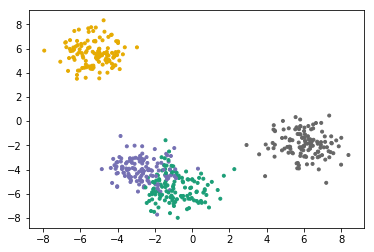

In [28]:
from sklearn.datasets import make_blobs

# generate blobs with fixed random generator
X, y = make_blobs(n_samples=500, centers=4, random_state=300)

plt.scatter(*X.T, c=y, marker='.', cmap='Dark2');

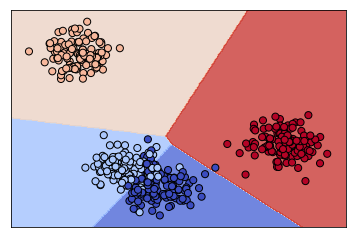

In [29]:
# By default LogisticRegression uses one-vs-rest strategy to deal with multi-class   
lr = LogisticRegression()
lr.fit(X,y)
plot_classifier(X,y, lr);

#### One-vs-rest scheme

- Uses "one-vs-rest" scheme (also known as one-vs-all)
  - turns $k$-class classification into $k$ binary classification problems
  - each one gives a probability of that class
  - take the max probability across classifiers as the class
  - you can do this yourself for any binary classifier using the meta-classifier [`OneVsRestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html)

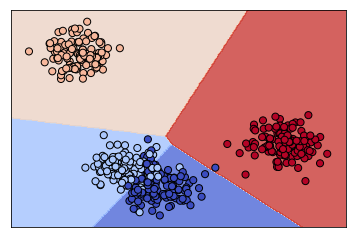

In [30]:
ovr = OneVsRestClassifier(LogisticRegression())
ovr.fit(X,y)
plot_classifier(X, y, ovr)

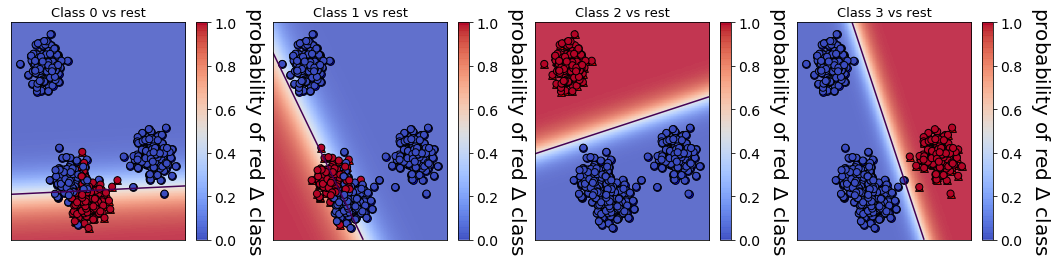

In [31]:
# Here's how one-vs-rest works:
def one_vs_rest_plots(model_class, X, y):
    plt.figure(figsize=(18,4))
    classes = np.unique(y)
    k = len(classes)
    for i,c in enumerate(classes):
        plt.subplot(1,k,i+1)
        
        y_binary = y == c
        model = model_class()
        model.fit(X, y_binary)
        plot_classifier(X, y_binary, model, ax=plt.gca(), proba=True);
        plt.title("Class %d vs rest" % c, fontsize=13);
        
one_vs_rest_plots(LogisticRegression, X, y)

#### Predictions with One-vs-rest strategy 
- Consider four different probabilities in the above case
- Take max of the 4 probabilities at any given point
- The class with the maximum probability is the prediction 

### Multi-class SVMs

- A multi-class linear SVM looks similar, though it's done with "one-vs-one" instead of one-vs-rest
  - This requires fitting $O(k^2)$ classifiers, which is slow
  - How many models need to be trained for the ImageNet challenge (which has 1000 classes)  
- Note that `SVC` multiclass mode is implemented using one-vs-one scheme whereas `LinearSVC` uses one-vs-rest scheme. 
- That said, we can use the OneVsRestClassifier wrapper to implement one-vs-rest with SVC.
- [Here](https://scikit-learn.org/stable/modules/multiclass.html) you will find summary of how `scikit-learn` handles multi-class classification for different classifiers. 
  

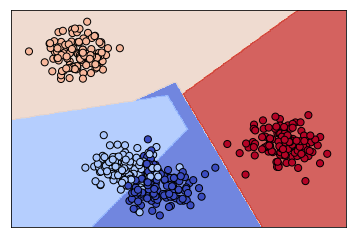

In [32]:
svm = SVC(kernel="linear")
svm.fit(X,y)
plot_classifier(X, y, svm);

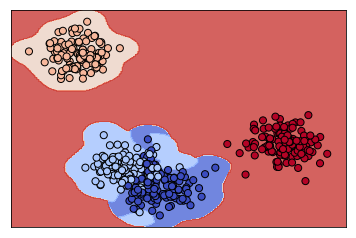

In [33]:
# Here's a multi-class nonlinear SVM:
svm_multi = SVC(kernel="rbf", gamma=2, C=100)
svm_multi.fit(X,y)
plot_classifier(X, y, svm_multi);

#### When do we use  `OneVsRestClassifier` and ``OneVsOneClassifier``

- It's not that likely for you to need `OneVsRestClassifier` or `OneVsOneClassifier` because most of the methods you'll use will have native multi-class support. 
- However, it's good to know in case you ever need to extend a binary classifier (perhaps one you've implemented on your own).

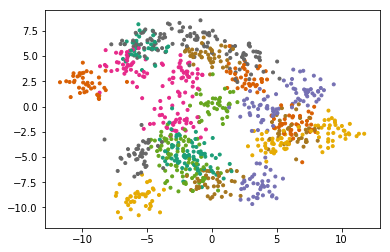

In [64]:
# Let's examine the time taken by OneVsRestClassifier and OneVsOneClassifier

# generate blobs with fixed random generator
X_multi, y_multi = make_blobs(n_samples=1000, centers=25, random_state=300)

X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X_multi, y_multi)

plt.scatter(*X_multi.T, c=y_multi, marker='.', cmap='Dark2');

#### Let's examine the time and accuracy of two methods

In [65]:
model = OneVsOneClassifier(SVC(gamma = 'scale'))
%timeit model.fit(X_train_multi, y_train_multi);
print('With OVO wrapper')
print(model.score(X_train_multi, y_train_multi))
print(model.score(X_test_multi, y_test_multi))

168 ms ± 1.66 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
With OVO wrapper
0.752
0.712


In [66]:
model = OneVsRestClassifier(SVC(gamma='scale'))
%timeit model.fit(X_train_multi, y_train_multi);
print('With OVO wrapper')
print(model.score(X_train_multi, y_train_multi))
print(model.score(X_test_multi, y_test_multi))

42.2 ms ± 361 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
With OVO wrapper
0.6626666666666666
0.648


### Random Forests: Motivation 

<blockquote>
Randomness works well in search sometimes better than humans.
    
by Nassim Nicholas Taleb    
</blockquote>

<blockquote>    
Michael Kearns (1988):
    
*Can a set of weak learners create a single strong learner?*
</blockquote>


#### Random forests

- General ideal
    - `fit` a diverse set of classifiers by **injecting randomness** in the classifier construction
    - `predict` by taking the average of predictions given by individual classifiers

- How do we inject randomness in the classifier construction? 
    1. Data: Build each tree on a bootstrap sample (i.e., a sample drawn **with replacement** from the training set)
    2. Features: 
        - Consider a random subset of features at each split (`RandomForestClassifier`)
        - Consider a random subset of features at each split and random threshold (`ExtraTreesClassifier`)   

#### The random forests classifier 

- Create a collection (ensemble) of trees. Grow each tree on an independent bootstrap sample from the data.
- At each node:
    - Randomly select a subset of features out of all features (independently for each node).
    - Find the best split on the selected features. 
    - Grow the trees to maximum depth.
    - Vote the trees to get predictions for new data. 

In [4]:
# You can download the IMDB movie review data set from here. This is the same one you used in lab 2. 
# https://www.kaggle.com/utathya/imdb-review-dataset
# Read IMDB movie reviews into a pandas DataFrame
imdb_df = pd.read_csv('data/imdb_master.csv', encoding = "ISO-8859-1")
# Only keep the reviews with pos and neg labels
imdb_df = imdb_df[imdb_df['label'].str.startswith(('pos','neg'))]
imdb_df.head(4)

,Unnamed: 0,type,review,label,file
0,0,test,"Once again Mr. Costner has dragged out a movie for far longer than necessary. Aside from the terrific sea rescue sequences, of which there are very few I just did not care about any of the charact...",neg,0_2.txt
1,1,test,"This is an example of why the majority of action films are the same. Generic and boring, there's really nothing worth watching here. A complete waste of the then barely-tapped talents of Ice-T and...",neg,10000_4.txt
2,2,test,"First of all I hate those moronic rappers, who could'nt act if they had a gun pressed against their foreheads. All they do is curse and shoot each other and acting like clichÃ©'e version of gangst...",neg,10001_1.txt
3,3,test,"Not even the Beatles could write songs everyone liked, and although Walter Hill is no mop-top he's second to none when it comes to thought provoking action movies. The nineties came and social pla...",neg,10002_3.txt


In [7]:
from sklearn.linear_model import LogisticRegression
# For converting words into frequency counts
from sklearn.feature_extraction.text import CountVectorizer
X_train_imdb, X_test_imdb, y_train_imdb, y_test_imdb = train_test_split(imdb_df['review'], 
                                                                        imdb_df['label'], 
                                                                        test_size = 0.20, 
                                                                        random_state = 12)

vec = CountVectorizer(max_features=5000,                       
                      stop_words='english')

# "fit" the vectorizer on the training data only*
X_train_counts = vec.fit_transform(X_train_imdb) 

# Only transform on the test data.  
X_test_counts = vec.transform(X_test_imdb) 

In [11]:
%%time
dt = tree.DecisionTreeClassifier(max_depth=20)
dt.fit(X_train_counts, y_train_imdb)
show_scores(dt, X_train_counts, y_train_imdb, X_test_counts, y_test_imdb) 

Model:  DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=20,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Training error:   0.17
Validation error: 0.26



CPU times: user 12.6 s, sys: 181 ms, total: 12.8 s
Wall time: 13 s


In [12]:
vocab = vec.get_feature_names()
graph = save_and_show_decision_tree(dt, feature_names = vocab, class_names = ['neg','pos'])

In [14]:
%%time
# Estimators with max_depth 2 for illustration purposes. 
# Usually it's better to have higher depth.  
rf = RandomForestClassifier(n_estimators = 100, max_depth = 2)
rf.fit(X_train_counts, y_train_imdb)
show_scores(rf,X_train_counts, y_train_imdb, X_test_counts, y_test_imdb) 

Model:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Training error:   0.20
Validation error: 0.21



CPU times: user 2.57 s, sys: 78.6 ms, total: 2.64 s
Wall time: 2.77 s


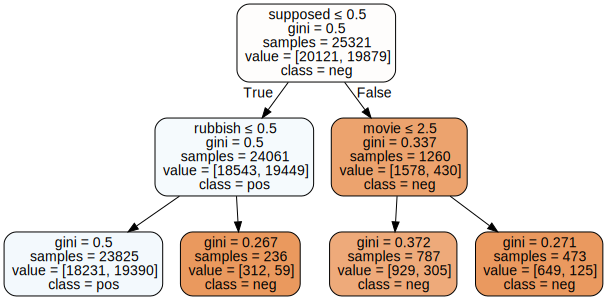

In [15]:
# Let's look at one of the estimators 
estimator = rf.estimators_[22]
graph = save_and_show_decision_tree(estimator, feature_names = vocab, class_names = ['neg','pos'])
graph

In [17]:
with open("data/citiesSmall.pkl", "rb") as f:
    data = pickle.load(f)
X_train = data['X']
y_train = data['y']

X_test = data['Xtest']
y_test = data['ytest']


#### Random forests: number of trees and the fundamental tradeoff 

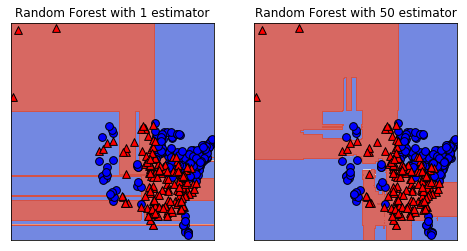

In [18]:
# Let's examine how the decision boundaries change with the number of estimators

rf_1 = RandomForestClassifier(n_estimators=1)
rf_1.fit(X_train,y_train)


rf_50 = RandomForestClassifier(n_estimators=50)
rf_50.fit(X_train,y_train)

# Plot Random Forest with 1 estimator
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plot_classifier(X_train, y_train, rf_1, ax=plt.gca())
plt.title("Random Forest with 1 estimator");

# Plot Random Forest with 50 estimator
plt.subplot(1,2,2)
plot_classifier(X_train, y_train, rf_50, ax=plt.gca())
plt.title("Random Forest with 50 estimator");

In [21]:
def make_num_tree_plot(X_train, y_train, X_test, y_test, num_trees):
    """
    Make number of trees vs error rate plot for RandomForestClassifier
   
    Parameters
    ----------
    model: sklearn classifier model
        The sklearn model
    X_train: numpy.ndarray        
        The X part of the train set
    y_train: numpy.ndarray
        The y part of the train set    
    X_test: numpy.ndarray        
        The X part of the test/validation set
    y_test: numpy.ndarray
        The y part of the test/validation set    
    num_trees: int
        The value for `n_estimators` argument of RandomForestClassifier
    Returns
    -------
        None
        Shows the number of trees vs error rate plot
            
    """    
    train_err = []
    test_err = []
    for ntree in num_trees:
        model = RandomForestClassifier(n_estimators=ntree)
        model.fit(X_train, y_train)
        train_err.append(1-model.score(X_train, y_train))
        test_err.append(1-model.score(X_test, y_test))

    plt.semilogx(num_trees,train_err,label="train");
    plt.semilogx(num_trees,test_err,label="test");
    plt.legend();
    plt.xlabel('number of trees');
    plt.ylabel('error rate');

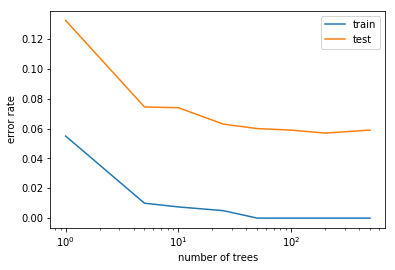

In [22]:
make_num_tree_plot(X_train, y_train, X_test, y_test, (1,5,10,25,50,100,200,500))

#### Number of trees and fundamental trade-off

- Above: seems like we're beating the fundamental "tradeoff" by decreasing training error and not increasing approximation error.
- This is the promise of ensembles, though it's not guaranteed to work so nicely.

#### Why does this work? 
- The idea is that if you have many weak learners that only need to perform marginally better than random guessing. 
- We will talk more about this next week when we discuss bagging. 

### Random forests vs decision trees

- Accuracy
    - Random forests are usually more accurate compared to decision trees, in fact they are usually one of the best performing off-the-shelf classifiers. 
    - [The original random forests paper](https://www.stat.berkeley.edu/~breiman/randomforest2001.pdf) by Leo Breiman notes that the error rate depends upon the following:  
        - The correlation between any two trees in the forest. Higher the correlation higher the error rate.
        - The error rate of each individual tree in the forest. Lowering the error rate of the individual trees decreases the forest error rate.

- Speed?
    - Slower than decision trees because we are fitting multiple trees 
    - But can easily parallelize training because all trees are independent of each other 
- Overfitting
    - No depth decision tree tends to overfit 
    - Random forests are less likely to overfit
- Interpretability
    - Decision trees are more interpretable 

### Summary

- SVMs 
    - Chooses the hyperplane that maximizes the margin between positive and negative example
    - Only the support vectors contribute to the solution
    - Using "kernels" allows you to deal with data that's not linearly separable. 
    - Although we didn't talk about it, SVMs can also be used for regression. See `scikit-learn`'s [`SVR`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html) classifier. 
- Multi-class classification
    - Two main approaches: OVR, OVO
    - Most of the classifiers you use have native support for multi-class classification (e.g., LogisticRegression)
    - But if there is no support, you should use `OneVsOneClassifier` and `OneVsRestClassifier`
    - Note: In lab 3, we ask you to use these strategies with `SVC` classifier so that you know how to use them.     
    
- Random Forests    

#### True or False questions on Random Forests 

1. Every tree in a random forest uses a different bootstrap sample of the training set.
2. To train a tree in a random forest, we first randomly select a subset of features. The tree is then restricted to only using those features. 
3. A reasonable implementation of `predict_proba` for random forests would be for each tree to "vote" and then normalize these vote counts into probabilities.
4. Like decision trees, but unlike most ML models, the running time of calling `predict` for a random forest is independent of $d$.



<br><br><br><br><br><br><br><br><br>

#### More True or False questions on Random Forests 

1. Increasing the hyperparameter `max_features` (the number of features to consider for a split) makes the model more complex and moves the fundamental tradeoff toward lower training error.
2. Increasing the hyperparameter `n_estimators` (the number of trees) makes the model more complex and moves the fundamental tradeoff toward lower training error.
3. A random forest with only one tree would tend to get a higher training error than a decision tree of the same depth.
4. Calling `fit` for a random forest with more than one tree (`n_estimators=1`) will be slower than calling `fit` for a decision tree (assuming the other hyperparameters are the same in both cases).

<br><br><br><br><br><br><br><br><br>

#### Relevant papers

- [Fernandez-Delgado et al. 2014](http://jmlr.org/papers/volume15/delgado14a/delgado14a.pdf) compared 179 classifiers on 121 datasets:
    - First best class of methods was Random Forest and second best class of methods was (RBF) SVMs.

- If you like to read original papers [here](https://www.stat.berkeley.edu/~breiman/randomforest2001.pdf) is the original paper on Random Forests by Leo Breiman. 

# DSCI 571 Lecture 7: Ensemble methods


UBC Master of Data Science program, 2019-20

Instructor: Varada Kolhatkar [ʋəɾəda kɔːlɦəʈkər]

In [1]:
# Lecture 1
from sklearn import tree 
from sklearn.tree import DecisionTreeClassifier

# Lecture 2
from sklearn.model_selection import train_test_split 

# Lecture 3
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from statsmodels.nonparametric.smoothers_lowess import lowess

# Lecture 4
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.preprocessing import normalize, scale, Normalizer, StandardScaler

# Lecture 5
from sklearn.linear_model import LogisticRegression, LinearRegression


# Lecture 6
from sklearn.svm import SVC, SVR, LinearSVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.ensemble import RandomForestClassifier

# Lecture 7
from sklearn.ensemble import VotingClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

# Installation of xgboost (on my MacBook):
# conda install py-xgboost

# You might need to install `nomkl` as well. 
# See here: https://github.com/dmlc/xgboost/issues/1715)
# conda install nomkl

# Windows users, try the latest version. If it doesn't work, try this older version 0.80.
# I have seen it working on Windows. 
# pip install xgboost==0.80

from xgboost import XGBClassifier
import xgboost as xgb

# See the installation instructions for lightGBM here: https://pypi.org/project/lightgbm/
from lightgbm import LGBMClassifier


# Other
import numpy as np
import pandas as pd
import pickle 

import graphviz

from sklearn import datasets
from sklearn.datasets import make_blobs, make_regression, make_circles

# pip install git+git://github.com/mgelbart/plot-classifier.git
from plot_classifier import plot_classifier

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
pd.set_option("display.max_colwidth", 200)

import altair as alt

# pip install ipython-autotime
import autotime

alt.renderers.enable('notebook')
#alt.data_transformers.enable('json')

## Attribution: Many visualization code snippets are from Mike's lecture from last year. 

RendererRegistry.enable('notebook')

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
def show_scores(model, 
                X_train, y_train,
                X_valid, y_valid):
    """
    Shows train and test error 
    Parameters
    ----------
    model: sklearn classifier model
        The sklearn model
    X_train: numpy.ndarray        
        The X part of the train set
    y_train: numpy.ndarray
        The y part of the train set    
    X_valid: numpy.ndarray        
        The X part of the validation set
    y_valid: numpy.ndarray
        The y part of the validation set    
    Returns
    -------
        None
        prints the train and validation errors. 
            
    """    
    #print('Model: ', model)
    print("Training error:   %.2f" % (1-model.score(X_train, y_train)))
    print("Validation error: %.2f" % (1-model.score(X_valid, y_valid)))
    print('\n\n')

In [4]:
# define a function to plot our model
def save_and_show_decision_tree(model, 
                                class_names,
                                feature_names,
                                save_file_prefix = 'test'):
    """
    Saves the decision tree model as a pdf and shows how the data is split and 
    classified

    Parameters
    ----------
    model: sklearn.tree.DecisionTreeClassifier
        The sklearn model decision tree
    class_names : list
        The names of all the possible classifications
    feature_names : list
        The names of all the features
    save_file_prefix: str
        The name you wish to save the file

    Returns
    -------
    graphviz.files.Source
        The decision tree graph
    """
    dot_data = tree.export_graphviz(model, out_file=None, 
                             feature_names=feature_names,  
                             class_names=class_names,  
                             filled=True, rounded=True,  
                             special_characters=True)  

    graph = graphviz.Source(dot_data) 
    graph.render(save_file_prefix) 
    return graph

### Clarification on OneVsRestClassifier

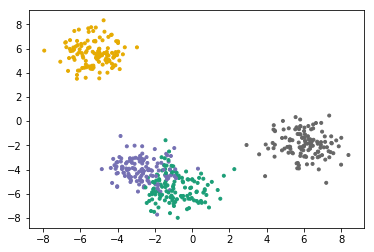

In [5]:
from sklearn.datasets import make_blobs

# generate blobs with fixed random generator
X, y = make_blobs(n_samples=500, centers=4, random_state=300)

plt.scatter(*X.T, c=y, marker='.', cmap='Dark2');

Class prediction probabilities:  [[2.80442918e-06 5.34580546e-02 9.45332309e-01 1.20683225e-03]]
Prediction probabilities for each estimator: 
[[9.99997033e-01 2.96660100e-06]]
[[0.94345062 0.05654938]]
[[1.92995365e-06 9.99998070e-01]]
[[0.99872338 0.00127662]]


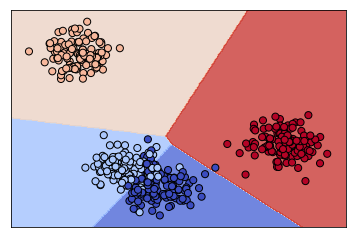

In [6]:
# Class prediction 
ovr = OneVsRestClassifier(LogisticRegression())
ovr.fit(X,y)
plot_classifier(X, y, ovr);
test_example = [[-5.60624566e+00,  6.65452311e+00]]
print('Class prediction probabilities: ', ovr.predict_proba(test_example))
print('Prediction probabilities for each estimator: ')
for estimator in ovr.estimators_:
    print(estimator.predict_proba(test_example))

#### Lecture plan

- True/False video questions (~10 mins)
- Motivation (~10 mins)
- Ensemble methods overview (~30 mins)
- Break (~5 mins)
- Gradient Boosting (~20 mins)
    - XGboost
    - LGBM
- Summary and wrap-up (~5 mins)

#### Today: Learning outcomes

From this lecture, students are expected to be able to: 

- Explain the intuition behind ensemble methods.
- At a high level, explain voting, bagging, and boosting and the differences between them.
- Use `scikit-learn` implementations of these ensemble methods.
- Use `XGboost` and `LGBM` ensembles via Python interface. 
- Compare ensemble methods with each other and with non-ensemble methods with respect to time and accuracy. 

#### Ensembles True/False video review questions (10 mins)

1. I can decide to average different models even _after_ I (or someone else) have already trained them.
2. With stacking (passing the output of several models into a "meta-model"), it might make sense to pass in the output of `predict_proba` instead of `predict`.
3. Let models A, B, and C have accuracies 90%, 70%, and 70%, respectively. Then, the maximum accuracy of an ensemble model is 90%. 
4. Let models A, B, and C have accuracies 70%, 70%, and 70%, respectively. Then, the minimum accuracy of an ensemble is 70%.
5. Ensembling works for both classification and regression.
6. Ensembling often increases accuracy but also increases the time spent fitting and predicting.

<br><br><br><br><br><br><br><br><br>

### Motivation
[The Wisdom of Crowds](http://wisdomofcrowds.blogspot.com/2009/12/introduction-part-i.html)
<img src="img/wisdom_of_crowds.jpg" width="500" height="500">

### Francis Galton
- Breeding mattered to Galton a lot and he believed that only a selected few had the characteristics necessary to keep societies healthy. He had devoted much of his career in measuring these characteristics. 

- His experiments left him with little faith in the intelligence of the average person.

<blockquote>
... the stupidity and wrong-headedness of many men and women being so great as to be scarcely credible.
</blockquote>


<img src="img/Francis_Galton.jpg" width="300" height="300">
Francis Galton (1822 -- 1911)


#### Plymouth weight-judging competition: How much this ox weighs? 

<img src="img/galton_ox.png" width="300" height="300">

- 800 participants wrote their guess on a piece of paper. (787 intelligible responses.)
- Galton undoubtedly thought that the average guess of the group would be way off the mark.
- But he calculated the mean and he was wrong!!
    - Crowd's guess: 1,197 pound; Real answer: 1,198 pound

#### Collective intelligence: Galton's changed view
<blockquote>
... under the right circumstances, groups are remarkably intelligent, and are often smarter than the smartest people in them. Groups do not need to be dominated by exceptionally intelligent people in order to be smart. Even if most of the people within a group are not especially well-informed or rational, it can still reach a collectively wise decision.
</blockquote>

#### Ensemble methods 

- We use the same intuition in ensembles
    - Use collective intelligence of a set of weak learners to build a strong learner. 

- How can we make an effective ensemble? 
    - **Key assumption: classifiers are independent in their predictions.**
    - If classifiers tend to make different kinds of errors ensembles tend to reduce the variance of classifiers.
    
<img src="img/doccam.png" width="200" height="200">    


<img src="img/ensemble.png" width="600" height="600">    
[Attribution](https://www.d.umn.edu/~rmaclin/cs8751/Notes/L14_Ensemble_Learning.pdf)

##### What do we combine? 
- Different learning algorithms
- Same learning algorithm trained in different ways
- Same learning algorithm trained the same way
- ...



<img src="img/ensemble.png" width="600" height="600">    
[Attribution](https://www.d.umn.edu/~rmaclin/cs8751/Notes/L14_Ensemble_Learning.pdf)

##### How do we combine?
- Majority voting 
- Majority voting where each vote is weighted by the probability of the classifier prediction 
- Majority voting where each classifier is weighted  
- A learned model on the prediction probabilities of different models (stacking) 
- ... 


#### Three general methods we are going to look at in this lesson 

- Majority voting
- Bagging 
- Boosting 

In [7]:
# Let's create train/test sets using the US voting data
with open("data/citiesSmall.pkl", "rb") as f:
    data = pickle.load(f)
X_train = data['X']
y_train = data['y']

X_test = data['Xtest']
y_test = data['ytest']

In [8]:
# Create a simple voting classifier using scikit-learn's VotingClassifier

classifiers = {
    "Decision tree"         : DecisionTreeClassifier(max_depth=5),
    "KNN"                   : KNeighborsClassifier(),
    "Naive Bayes"           : GaussianNB(),
    "Logistic Regression"   : LogisticRegression(),
    "SVM"                   : SVC(probability=True)
}


ensemble = VotingClassifier(classifiers.items(), voting="soft")

# note: sklearn doesn't seem to support passing pre-trained classifiers into VotingClassifier
ensemble.fit(X_train, y_train);

print('Ensemble performance: \n')
show_scores(ensemble, X_train, y_train, X_test, y_test)

Ensemble performance: 

Training error:   0.03
Validation error: 0.06





Above: `VotingClassifier` [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html) for argument `voting`:

> If ‘hard’, uses predicted class labels for majority rule voting. Else if ‘soft’, predicts the class label based on the argmax of the sums of the predicted probabilities, which is recommended for an ensemble of well-calibrated classifiers.

In [9]:
## What's the performance of individual classifiers in the ensemble?
for name, estimator in ensemble.named_estimators_.items(): # needs scikit-learn-0.20
    tr_err = (1 - estimator.score(X_train, y_train))
    te_err = (1 - estimator.score(X_test, y_test))
    print('%s: Train_error: %0.3f; Test error: %0.3f'%(name, tr_err, te_err))

Decision tree: Train_error: 0.065; Test error: 0.123
KNN: Train_error: 0.042; Test error: 0.069
Naive Bayes: Train_error: 0.338; Test error: 0.367
Logistic Regression: Train_error: 0.315; Test error: 0.339
SVM: Train_error: 0.022; Test error: 0.065


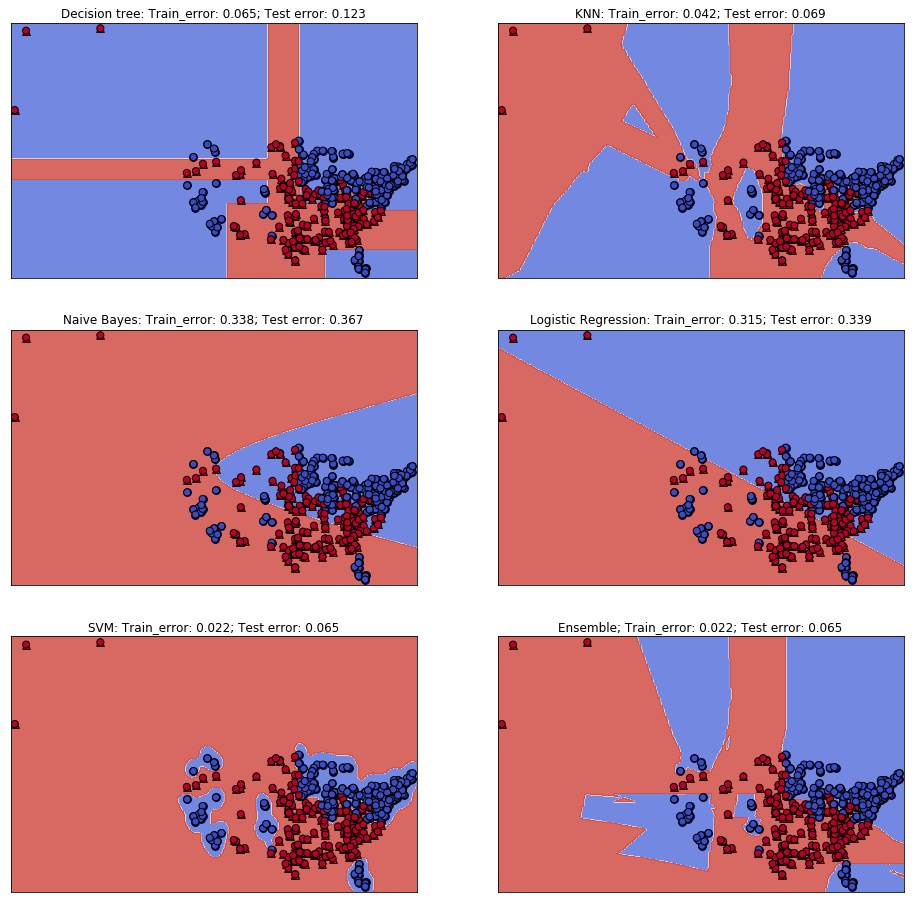

In [10]:
plt.figure(figsize=(16,16))
count = 1
for name, estimator in ensemble.named_estimators_.items(): # needs scikit-learn-0.20
    plt.subplot(3,2,count)
    plot_classifier(X_train, y_train, estimator, ax=plt.gca());
    tr_err = (1 - estimator.score(X_train, y_train))
    te_err = (1 - estimator.score(X_test, y_test))
    title = '%s: Train_error: %0.3f; Test error: %0.3f'%(name, tr_err, te_err)    
    plt.title(title);
    count += 1
    
plt.subplot(3,2,6)
plot_classifier(X_train, y_train, ensemble, ax=plt.gca());
tr_score = ensemble.score(X_train, y_train)
te_score = ensemble.score(X_test, y_test)
title = '%s; Train_error: %0.3f; Test error: %0.3f'%('Ensemble', tr_err, te_err)    
plt.title(title);

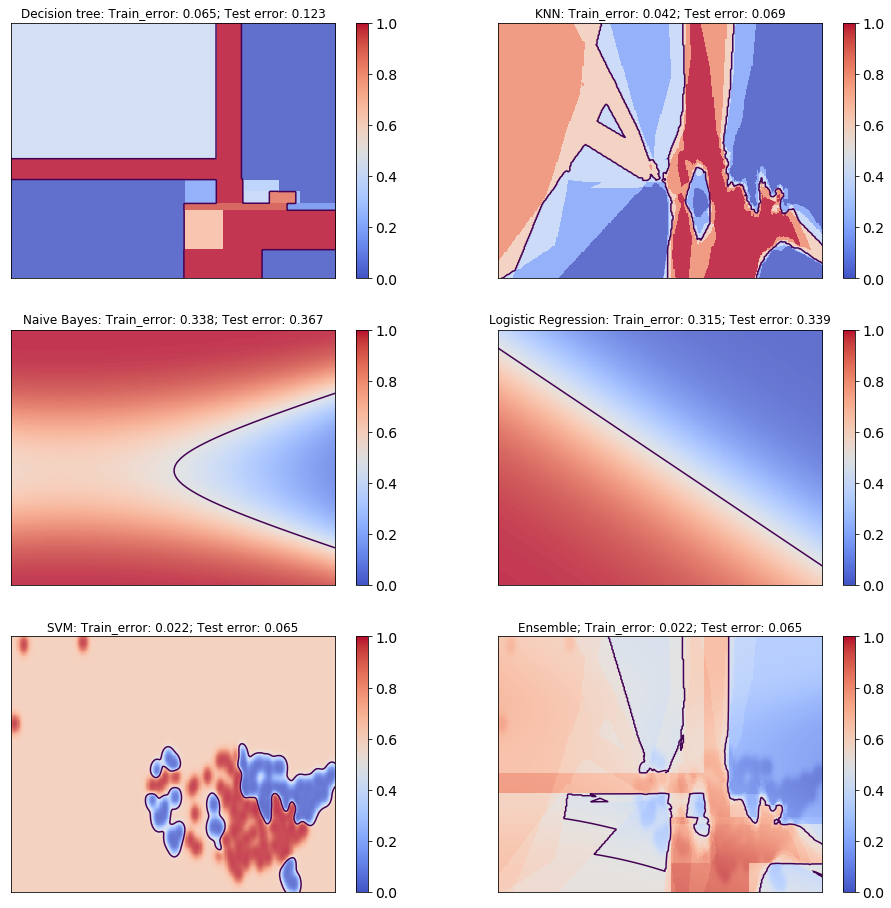

In [11]:
plt.figure(figsize=(16,16))
count = 1
for name, estimator in ensemble.named_estimators_.items(): # needs scikit-learn-0.20
    plt.subplot(3,2,count)
    plot_classifier(X_train, y_train, estimator, ax=plt.gca(), show_data=False, proba=True, proba_showtitle=False);
    tr_err = (1 - estimator.score(X_train, y_train))
    te_err = (1 - estimator.score(X_test, y_test))
    title = '%s: Train_error: %0.3f; Test error: %0.3f'%(name, tr_err, te_err)    
    plt.title(title);
    count += 1
plt.subplot(3,2,6)
plot_classifier(X_train, y_train, ensemble, ax=plt.gca(), show_data=False, proba=True, proba_showtitle=False);

tr_score = ensemble.score(X_train, y_train)
te_score = ensemble.score(X_test, y_test)
title = '%s; Train_error: %0.3f; Test error: %0.3f'%('Ensemble', tr_err, te_err)    
plt.title(title);

#### Some questions for you 

- Does majority voting make sense for regression? 
    - a simple solution is to take the mean or median
- What about multi-class classification?

#### Bagging (Bootstrap and Aggregate) 

- In `VotingClassifier` we considered a number of **distinct** classifiers and took a majority vote. 
- It is more common to use the same learning method with data set used for training varied. 
    - Random forests we saw in the last class used Bootstrap samples and took the majority vote. 
    - We also added an additional component of randomness; we randomly selected a set of features to choose from at each split.
    
    

In [12]:
from sklearn.utils import resample
import pandas as pd
# data sample

df = pd.DataFrame({
  'excellent': [1,1,0,0,0,0],
  'flawless': [0,0,1,0,0,0],
  'long':[1,0,0,0,0,1],
  'waste':[0,0,0,0,1,0],
  'unwatchable':[0,0,0,0,1,1],    
  'sentiment':['pos','pos','pos','neg','neg','neg']
})
df

,excellent,flawless,long,waste,unwatchable,sentiment
0,1,0,1,0,0,pos
1,1,0,0,0,0,pos
2,0,1,0,0,0,pos
3,0,0,0,0,0,neg
4,0,0,0,1,1,neg
5,0,0,1,0,1,neg


In [13]:
boot = resample(df, replace=True, n_samples=6)
print('Bootstrap Sample:')
# Bootstrapped sample
boot

Bootstrap Sample:


,excellent,flawless,long,waste,unwatchable,sentiment
0,1,0,1,0,0,pos
0,1,0,1,0,0,pos
3,0,0,0,0,0,neg
5,0,0,1,0,1,neg
1,1,0,0,0,0,pos
0,1,0,1,0,0,pos


### Boosting/gradient boosting

**Boosting** 

- General idea: add one "learner" (i.e. model) at a time, which addresses the "shortcomings" of the current ensemble.
  - For regression, the outputs are literally being added together.
  - The ensemble can be complex even if the base learner is simple (e.g., a decision stump)
- Unlike averaging, ensemble is created _during training_, not after.
- Many variants, detailed learning theory that informs the details.
- Works for both regression and classification, but easier to explain/understand with regression.
- Popular variant of boosting: `AdaBoost`

#### AdaBoost algorithm:

```
for each data points: weight w_i to 1/#datapoints
    for k = 1 to #classifiers
        generate classifier k with current weighted train set
        error_k = sum of w_i’s of misclassified points
        beta_k = (1 - error_k) / error_k
        multiply weights of all misclassified points by beta_k
        normalize weights to sum to 1
combine: weighted vote, weight for classifier k is log(beta_k)
```

#### AdaBoost Toy example 
<img src="img/AdaBoost_toy_example.png" width="800" height="800">

Source: Boosting_ Foundations and Algorithms (Schapire and Freund, 2012), Figure 1.2

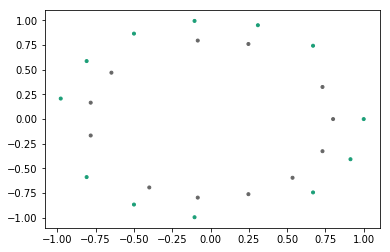

In [14]:
# Let's generate some fake data

# generate blobs with fixed random generator
n = 30
n_classes = 2
X, y = datasets.make_circles(n_samples=n, random_state = 122)

X_train_circ, X_test_circ, y_train_circ, y_test_circ = train_test_split(X, y, test_size=0.2)

# How does the data look like? 
plt.scatter(*X_train_circ.T, c=y_train_circ, marker='.', cmap='Dark2');

In [15]:
ensemble = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2), n_estimators = 4)
ensemble.fit(X_train_circ, y_train_circ);

/Users/kvarada/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


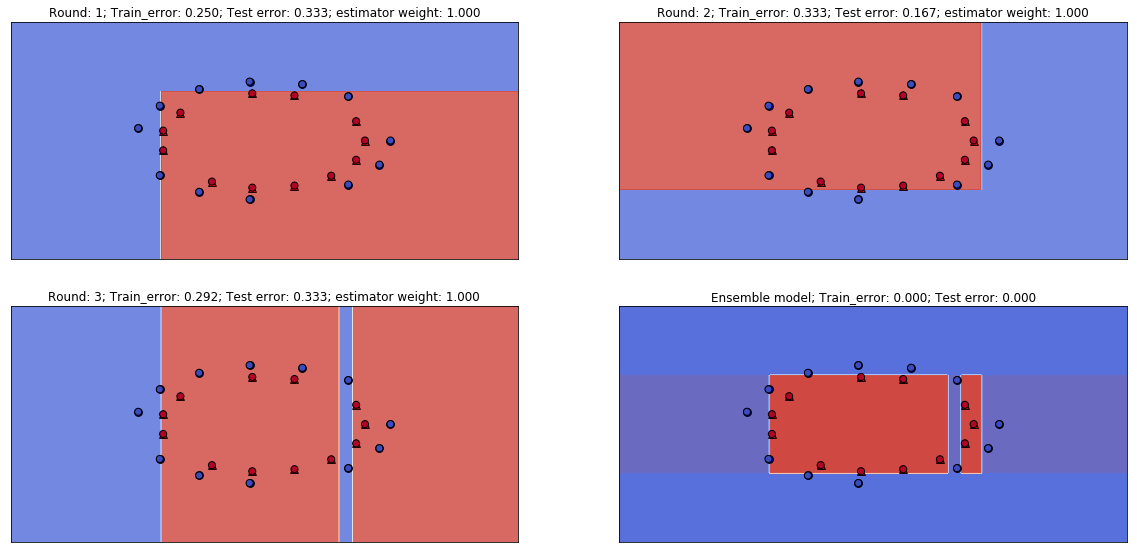

In [16]:
# Combine weak learners 
plt.figure(figsize=(20,20))
count = 0
weights = ensemble.estimator_weights_
for estimator in ensemble.estimators_: # needs scikit-learn-0.20
    plt.subplot(4,2,count+1)
    plot_classifier(X_train_circ, y_train_circ, estimator, ax=plt.gca());
    tr_err = (1 - estimator.score(X_train_circ, y_train_circ))
    te_err = (1 - estimator.score(X_test_circ, y_test_circ))
    title = 'Round: %i; Train_error: %0.3f; Test error: %0.3f; estimator weight: %0.3f'%(count+1, tr_err, te_err, weights[count])
    #title = 'Round: ' + str(count) + '; Train error = ' + str(tr_err) + 'weight: ' + estimator_weights_ 
    plt.title(title);
    count += 1
    
tr_err = (1 - ensemble.score(X_train_circ, y_train_circ))
te_err = (1 - ensemble.score(X_test_circ, y_test_circ))
title = 'Ensemble model; Train_error: %0.3f; Test error: %0.3f'%(tr_err, te_err)
plt.subplot(4,2,count)
plt.title(title)
plot_classifier(X_train_circ, y_train_circ, ensemble, ax=plt.gca());        

See also [`AdaBoostRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html).

**Gradient boosting**

- Gradient boosting is a particular _interpretation_ of boosting that allows generalizing it.
- To fully understand it, we need some ingredients from DSCI 572, so we'll skip it for now.
- (Optional) Gradient boosting interprets _predictions_ as _parameters_, then does gradient descent w.r.t. predictions. Each "iteration" adds a base model ("learner") to the ensemble.
- (Optional) See [here](http://www.chengli.io/tutorials/gradient_boosting.pdf) for some more info on gradient boosting.

In [17]:
model = GradientBoostingClassifier() # uses trees
model.fit(X_train_circ, y_train_circ);
show_scores(model, X_train_circ, y_train_circ, X_test_circ, y_test_circ)

Training error:   0.00
Validation error: 0.00





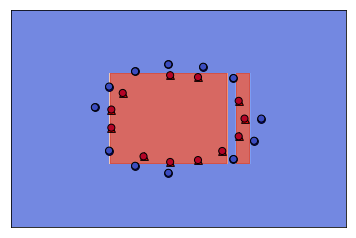

In [18]:
plot_classifier(X_train_circ, y_train_circ, model);

#### XGBoost (eXtreme Gradient Boosting)

- XGBoost is a particular industrial-strength implementation of gradient boosted trees.
- Not part of scikit-learn but supports a scikit-learn-like interface (my video shows the older interface)

Installation (on my Mac at least):

```
conda install py-xgboost
conda install nomkl
```

You might not need the latter but I am including it just in case. It is from [here](https://github.com/dmlc/xgboost/issues/1715).

Windows users, try the latest version first. If it does not work, try this older version 0.80.

```
pip install xgboost==0.80
```

In [19]:
### Let's try it on the dataset you used in lab3 

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

cats = ['sci.crypt', 'sci.electronics', 'sci.med', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers','footers','quotes'), categories = cats)
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers','footers','quotes'), categories = cats)

X_news_train, y_news_train = newsgroups_train.data, newsgroups_train.target
X_train, X_valid, y_train, y_valid = train_test_split(X_news_train, y_news_train, test_size=0.2, random_state=42)

X_test, y_test = newsgroups_test.data, newsgroups_test.target

In [20]:
# Extract tf-idf features 

vectorizer = TfidfVectorizer()
X_tfidf_train = vectorizer.fit_transform(X_train).tocsc()
X_tfidf_valid = vectorizer.transform(X_valid).tocsc()
X_tfidf_test = vectorizer.transform(X_test).tocsc()

In [21]:
# Let's check the size of each dataset
print('Train shape: {}'.format(X_tfidf_train.get_shape()))
print('Valid shape: {}'.format(X_tfidf_valid.get_shape()))
print('Test shape: {}'.format(X_tfidf_test.get_shape()))

Train shape: (1898, 27660)
Valid shape: (475, 27660)
Test shape: (1579, 27660)


In [22]:
%%time

# Let's first train a decision tree
dt = DecisionTreeClassifier()
dt.fit(X_tfidf_train, y_train)
show_scores(dt, X_tfidf_train, y_train, X_tfidf_test, y_test)

Training error:   0.02
Validation error: 0.44



CPU times: user 580 ms, sys: 4.91 ms, total: 585 ms
Wall time: 589 ms


In [23]:
%%time

# Let's first train a decision tree
rf = RandomForestClassifier()
rf.fit(X_tfidf_train, y_train)
show_scores(rf, X_tfidf_train, y_train, X_tfidf_test, y_test)

Training error:   0.02
Validation error: 0.44



CPU times: user 246 ms, sys: 4.16 ms, total: 251 ms
Wall time: 251 ms


In [32]:
%%time

# Now let's try XGBoost
xb = XGBClassifier(seed = 42, nthread = 1)
xb.fit(X_tfidf_train, y_train)
show_scores(xb, X_tfidf_train, y_train, X_tfidf_test, y_test)

Training error:   0.13
Validation error: 0.31



CPU times: user 12 s, sys: 75.7 ms, total: 12.1 s
Wall time: 12.3 s


In [25]:
# You can watch the progress of the algorithm by providing the validation set
xb = XGBClassifier(seed = 42, nthread = 1)
xb.fit(X_tfidf_train, y_train,
       eval_set = [(X_tfidf_train, y_train),(X_tfidf_valid,y_valid)],
       verbose = 10)
show_scores(xb, X_tfidf_train, y_train, X_tfidf_test, y_test)

[0]	validation_0-merror:0.379874	validation_1-merror:0.410526
[10]	validation_0-merror:0.30137	validation_1-merror:0.32
[20]	validation_0-merror:0.271865	validation_1-merror:0.311579
[30]	validation_0-merror:0.248683	validation_1-merror:0.301053
[40]	validation_0-merror:0.225501	validation_1-merror:0.290526
[50]	validation_0-merror:0.202318	validation_1-merror:0.288421
[60]	validation_0-merror:0.178609	validation_1-merror:0.271579
[70]	validation_0-merror:0.161222	validation_1-merror:0.258947
[80]	validation_0-merror:0.151739	validation_1-merror:0.265263
[90]	validation_0-merror:0.135406	validation_1-merror:0.252632
[99]	validation_0-merror:0.127503	validation_1-merror:0.252632
Training error:   0.13
Validation error: 0.31





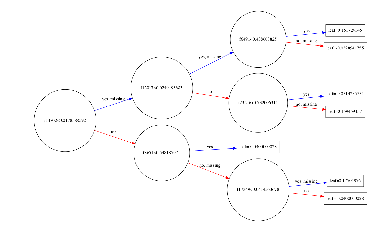

<Figure size 36000x14400 with 0 Axes>

In [38]:
#### Visualize Boosting Trees
import xgboost as xgb
xgb.plot_tree(xb, num_trees=0, rankdir='LR')
plt.figure(figsize=(500,200))
plt.show()

#### [Light GBM](https://github.com/microsoft/LightGBM)

- Another tree-based gradient boosting framework
- Great for large-scale datasets 
- Lower memory because of depth-first search like growth

In [39]:
%%time
lgb = LGBMClassifier()
lgb.fit(X_tfidf_train, y_train)
show_scores(lgb, X_tfidf_train, y_train, X_tfidf_test, y_test)

Training error:   0.02
Validation error: 0.32



CPU times: user 29.4 s, sys: 216 ms, total: 29.6 s
Wall time: 7.76 s


### Summary

- Ensemble methods
    - A good ensemble is one where the individual classifiers in the ensemble are both 
        - accurate 
        - make their errors on different parts of the input space. 
    - Bagging
        - Vary the dataset for each classifer in the ensemble using bootstrapping
        - Example: Random forests
    - Boosting/Gradient boosting 
        - Add one "learner" (i.e. model) at a time, which addresses the "shortcomings" of the current ensemble
        - Examples: AdaBoost, XGBoost and LGBM 
        - Extremely effective in practice
- All these methods can also be used for regression        

#### `XGBoost` and `LGBM` in practice

- Most of the winning solutions for Kaggle competitions involve some kind of ensembling. For example: 

<img src="img/fraud_detection_kaggle.png" width="500" height="500">

#### Optional but interesting stuff

- [GitHub repo of XGBoost](https://github.com/dmlc/xgboost), an efficient implementation of gradient boosting
- Chen's (one of the main author of XGBoost) [talk on XGboost](https://www.youtube.com/watch?v=zyjYlU7in3I)
- [GihHub repo of LightGBM](https://github.com/microsoft/LightGBM)
- [Video-lecture by Trevor Hastie](https://www.youtube.com/watch?v=wPqtzj5VZus) about GBM at h2o.ai conference

# DSCI 571 Lecture 8: Putting it all together 


UBC Master of Data Science program, 2019-20

Instructor: Varada Kolhatkar [ʋəɾəda kɔːlɦəʈkər]

In [4]:
# Lecture 1
from sklearn import tree 
from sklearn.tree import DecisionTreeClassifier

# Lecture 2
from sklearn.model_selection import train_test_split 

# Lecture 3
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from statsmodels.nonparametric.smoothers_lowess import lowess

# Lecture 4
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.preprocessing import normalize, scale, Normalizer, StandardScaler, OneHotEncoder

# Lecture 5
from sklearn.linear_model import LogisticRegression, LinearRegression

# Lecture 6
from sklearn.svm import SVC, SVR, LinearSVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.ensemble import RandomForestClassifier

# Lecture 7
from sklearn.ensemble import VotingClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# Lecture 8
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.preprocessing import FunctionTransformer

# Other
import numpy as np
import pandas as pd
import pickle 

import graphviz

from sklearn import datasets
from sklearn.datasets import make_blobs, make_hastie_10_2
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer


# pip install git+git://github.com/mgelbart/plot-classifier.git
from plot_classifier import plot_classifier

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
pd.set_option("display.max_colwidth", 200)

import altair as alt
import time

# pip install ipython-autotime
import autotime

# alt.renderers.enable('notebook')
#alt.data_transformers.enable('json')

## Attribution: Many visualization code snippets are from Mike's lecture from last year. 

In [5]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [6]:
def get_scores(model, 
                X_train, y_train,
                X_valid, y_valid, 
                show = True
               ):
    """
    Returns train and validation error given a model
    train and validation X and y portions
    Parameters
    ----------
    model: sklearn classifier model
        The sklearn model
    X_train: numpy.ndarray        
        The X part of the train set
    y_train: numpy.ndarray
        The y part of the train set    
    X_valid: numpy.ndarray        
        The X part of the validation set
    y_valid: numpy.ndarray
        The y part of the validation set    
    Returns
    -------
        train_err: float
        test_err: float
            
    """    
    if show: 
        print("Training error:   %.2f" % (1-model.score(X_train, y_train)))
        print("Validation error: %.2f" % (1-model.score(X_valid, y_valid)))
        print('\n')
    return (1-model.score(X_train, y_train)), (1-model.score(X_valid, y_valid))

#### Lecture plan

- ML pipeline (~40 mins)
- Break (~5 mins)
- Evaluations (~15 mins)
- Time complexity of ML algorithms (~10 mins)
- Summary and wrap-up (~5 mins)

#### Big ideas we have learned so far in the course

1. `fit`/`predict` paradigm
2. Overfitting, underfitting, the fundamental tradeoff
3. Validation, cross-validation
4. Visualizing regression/classification "surfaces"
5. Parametric vs. non-parametric methods
6. Feature preprocessing (e.g., scaling, one-hot-encoding)
7. Ensembling
8. Hyperparameters searches
9. A number of specific methods

#### Today: Learning outcomes

From this lecture, students are expected to be able to: 

- Build a machine learning pipeline for a given problem.
- Use `sklearn.pipeline.Pipelines` to a build such a pipeline elegantly.
- Able to analyze the results at each step of the pipeline. 
- Compare different algorithms we have seen so far with respect to time complexity. 

## ML pipeline demo 

In [10]:
### Pick a problem 
### Predict whether income exceeds $50K/yr based on census data

# I don't think I should be distributing this CSV. So I haven't 
# pushed it in the repo. 
# You can download it from the following link and put it in the 
# data dir in your local version. 
# https://www.kaggle.com/uciml/adult-census-income#
df = pd.read_csv('data/adult.csv')
df.head(10)

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
5,34,Private,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States,<=50K
6,38,Private,150601,10th,6,Separated,Adm-clerical,Unmarried,White,Male,0,3770,40,United-States,<=50K
7,74,State-gov,88638,Doctorate,16,Never-married,Prof-specialty,Other-relative,White,Female,0,3683,20,United-States,>50K
8,68,Federal-gov,422013,HS-grad,9,Divorced,Prof-specialty,Not-in-family,White,Female,0,3683,40,United-States,<=50K
9,41,Private,70037,Some-college,10,Never-married,Craft-repair,Unmarried,White,Male,0,3004,60,?,>50K


In [11]:
# Replace ? with NaN because it's easier to work with them 
df = df.replace('?', "NaN")
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,NaN,77053,HS-grad,9,Widowed,NaN,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,NaN,186061,Some-college,10,Widowed,NaN,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [12]:
### Create X and y

X = df.drop(['income'], axis=1)
y = df['income']

### Step 1: ?

#### What should be the first step? 

In [13]:
def split_data(X, y):
    """
    Shows train and test error 
    Parameters
    ----------
    model: sklearn classifier model
        The sklearn model
    X: numpy.ndarray        
        The X part (features) of the dataset
    y numpy.ndarray
        The y part (target) of the dataset
    Returns
    -------        
        X_train: numpy.ndarray
            The X part of the train dataset
        y_train: numpy.ndarray  
            The y part of the train dataset
        X_valid: numpy.ndarray  
            The X part of the validation dataset        
        y_valid
            The y part of the validation dataset        
        X_trainvalid
            The X part of the train+validation dataset        
        y_trainvalid
            The y part of the train+validation dataset        
        X_test
            The X part of the test dataset        
        y_test            
            The y part of the test dataset        
    """
    X_trainvalid, X_test, y_trainvalid, y_test = train_test_split(X, y, train_size=0.8, random_state=22)
    X_train, X_valid, y_train, y_valid = train_test_split(X_trainvalid, y_trainvalid, 
                                                          train_size=0.75, random_state=22)

    print("Number of training examples:", len(y_train))
    print("Number of validation examples:", len(y_valid))
    print("Number of test examples:", len(y_test))
    
    return X_train, y_train, X_valid, y_valid, X_trainvalid, y_trainvalid, X_test, y_test

In [14]:
### First thing you do before even looking at your dataset is splitting 

X_train, y_train, X_valid, y_valid, X_trainvalid, y_trainvalid, X_test, y_test = split_data(X,y)

Number of training examples: 19536
Number of validation examples: 6512
Number of test examples: 6513


### Step 2: EDA 

- We are only doing preliminary EDA here but don't get the wrong idea; it's an important step in the pipeline.

In [15]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19536 entries, 8128 to 10569
Data columns (total 14 columns):
age               19536 non-null int64
workclass         19536 non-null object
fnlwgt            19536 non-null int64
education         19536 non-null object
education.num     19536 non-null int64
marital.status    19536 non-null object
occupation        19536 non-null object
relationship      19536 non-null object
race              19536 non-null object
sex               19536 non-null object
capital.gain      19536 non-null int64
capital.loss      19536 non-null int64
hours.per.week    19536 non-null int64
native.country    19536 non-null object
dtypes: int64(6), object(8)
memory usage: 2.2+ MB


In [16]:
X_train.describe()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
count,19536.000000,1.953600e+04,19536.000000,19536.000000,19536.000000,19536.000000
mean,38.442414,1.899464e+05,10.077703,1074.497133,87.015612,40.460893
std,13.628669,1.051693e+05,2.573318,7435.154917,402.138382,12.407339
min,17.000000,1.376900e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.180010e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.785305e+05,10.000000,0.000000,0.000000,40.000000
75%,47.000000,2.372398e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.366120e+06,16.000000,99999.000000,4356.000000,99.000000


In [17]:
# Let's identify numeric and categorical features

numeric_features = ['age', 'fnlwgt', 'education.num', 
                    'capital.gain', 'capital.loss', 
                    'hours.per.week']

categorical_features = ['workclass', 'education', 'marital.status', 
                        'occupation', 'relationship', 
                        'race', 'sex', 'native.country']

In [18]:
feat_val_dict = {}
for feat in categorical_features:
    print('Feature: %s' %(feat))
    print('------------')
    print(df[feat].value_counts())
    print('\n\n')

Feature: workclass
------------
Private             22696
Self-emp-not-inc     2541
Local-gov            2093
NaN                  1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64



Feature: education
------------
HS-grad         10501
Some-college     7291
Bachelors        5355
Masters          1723
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           646
Prof-school       576
9th               514
12th              433
Doctorate         413
5th-6th           333
1st-4th           168
Preschool          51
Name: education, dtype: int64



Feature: marital.status
------------
Married-civ-spouse       14976
Never-married            10683
Divorced                  4443
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: marital.status, dtype: i

#### Things you can try 

- Visualize the above frequencies for each features.
- Examine the correlation of numeric features with each other and with the target variable. 
- ...

### Step 3: Preprocessing

### Some example preprocessing steps

- Missing values
    - Replace them by 0 or some value that's unlikely to occur in the column or 
    - Replace them by the most common value in the column 
    - Use `scikit-learn`'s `SimpleImputer`
- One-hot encoding 

#### Traditional approach for preprocessing

- For each transform do 
    - identify the columns on which the transform needs to be applied
    - `fit_transform` on the train portion
    - `transform` on the validation and test portions  

In [19]:
# Impute numeric missing values by the median 
imp = SimpleImputer(strategy='median')
X_num_train = imp.fit_transform(X_train[numeric_features])
X_num_valid = imp.transform(X_valid[numeric_features])

# Impute categorical missing values by a constant string
# You may replace it with the most frequent value 
# corresponding to each column
imp = SimpleImputer(strategy='constant', fill_value='missing')
X_cat_train = imp.fit_transform(X_train[categorical_features])
X_cat_valid = imp.transform(X_valid[categorical_features])

# Then you have to put the Xs created by numeric 
# and categorical transformations together

#### Pipelines motivation 

- What would you do if you want to do cross-validation? 
- With many different transformations and cross validation the code gets unwieldy very quickly
- Likely to make mistakes 

Can we do this in a more elegant and organized way?
- YES!! Using [`scikit-learn Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html).
- [`scikit-learn Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) allows you to define a "pipeline" of transforms with a final estimator.
- You have seen it in Lab 3 solutions.

In [20]:
### Simple example of a pipeline

cats = ['sci.crypt', 'sci.electronics', 'sci.med', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers','footers','quotes'), categories = cats)
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers','footers','quotes'), categories = cats)

X_news_train, y_news_train = newsgroups_train.data, newsgroups_train.target
X_n_train, X_n_valid, y_n_train, y_n_valid = train_test_split(X_news_train, y_news_train, test_size=0.2, random_state=42)

pipeline = Pipeline(steps=[
    ('vect', CountVectorizer()),
    ('clf', LogisticRegression()),
])

In [21]:
pipeline.fit(X_n_train, y_n_train)
get_scores(pipeline, X_n_train, y_n_train, X_n_valid, y_n_valid, show = 'True')

Training error:   0.02
Validation error: 0.20




(0.020547945205479423, 0.1957894736842105)

In [22]:
# Let's build a pipeline for our dataset 
# create the preprocessing pipelines for both numeric and categorical data.

numeric_transformer = Pipeline(steps=[
                                      ('imputer', SimpleImputer(strategy='median')),
                                      ('scaler', StandardScaler())
                                    ])


categorical_transformer = Pipeline(steps=[
                                          ('imputer', SimpleImputer(strategy='constant', 
                                                                    fill_value='missing')),
                                          ('onehot', OneHotEncoder(handle_unknown='ignore'))
                                         ])

preprocessor = ColumnTransformer(
                                 transformers=[
                                    ('num', numeric_transformer, numeric_features),
                                    ('cat', categorical_transformer, categorical_features)
                                ])

### Step 4: Build a baseline model 

In [23]:
# Lets create an empty dictionary to store all the results
results_dict = {}        

### Baseline model 

- Try `scikit-learn`'s `DummyClassifier` as a baseline model.
> Documentation: DummyClassifier is a classifier that makes predictions using simple rules.
> This classifier is useful as a simple baseline to compare with other (real) classifiers. Do not use it for real problems.

In [24]:
# Baseline model
from sklearn.dummy import DummyClassifier
print('Fitting baseline model: ')
dummy = DummyClassifier()

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', dummy)])

t = time.time()
clf.fit(X_train, y_train)
tr_err, valid_err = get_scores(clf, X_train, y_train, X_valid, y_valid)
elapsed_time = time.time() - t
results_dict['dummy'] = [round(tr_err,3), round(valid_err,3), round(elapsed_time,4)]

Fitting baseline model: 
Training error:   0.36
Validation error: 0.36




In [31]:
# X_train

### Step 5: Try different classifiers

In [25]:
### Try different classifiers

models = {
          'decision tree': DecisionTreeClassifier(),
          'kNN': KNeighborsClassifier(),
          'logistic regression': LogisticRegression(),
          'RBF SVM' : SVC(), 
          'random forest' : RandomForestClassifier(), 
          'xgboost' : XGBClassifier(),
          'lgbm': LGBMClassifier()
         }

for model_name, model in models.items():
    t = time.time()
    #print(model_name, ":")    
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', model)])
    clf.fit(X_train, y_train);
    tr_err, valid_err = get_scores(clf, X_train, y_train, 
                                   X_valid, y_valid, show = False)
    elapsed_time = time.time() - t
    results_dict[model_name] = [round(tr_err,3), round(valid_err,3), round(elapsed_time,4)]
    #print("Elapsed time: %.1f s" % elapsed_time)

In [26]:
results_df = pd.DataFrame(results_dict).T
results_df.columns = ["Train error", "Validation error", "Time in seconds"]
results_df

,Train error,Validation error,Time in seconds
dummy,0.360,0.360,0.2838
decision tree,0.000,0.181,0.7291
kNN,0.117,0.170,20.0670
logistic regression,0.146,0.151,0.2180
RBF SVM,0.147,0.148,14.0773
random forest,0.012,0.154,1.0792
xgboost,0.132,0.139,1.1434
lgbm,0.107,0.132,0.3521


####  Observations

- kNN and SVM seem to be too slow. 
    - Let's abandon them. 
- Decision tree is clearly overfitting
- Logistic regression is the fastest one. 
- Let's try hyperparameter optimization with logistic regression 

### Step 6: Hyperparameter optimization 

In [27]:
# Hyperparameter optimization 

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])

param_grid = {
    'preprocessor__num__imputer__strategy': ['mean', 'median'],
    'classifier__C': [0.1, 1.0, 10, 100],
}

grid_search = GridSearchCV(clf, param_grid, cv=10)
grid_search.fit(X_trainvalid, y_trainvalid)

print(("best logistic regression from grid search: %.3f"
       % grid_search.score(X_valid, y_valid)))

best logistic regression from grid search: 0.851


In [28]:
grid_search.best_params_
tr_err, valid_err = get_scores(grid_search, X_train, y_train, X_valid, y_valid)
#results_dict['logistic regression (best params)'] = [round(tr_err,3), round(valid_err,3), 'NA']

Training error:   0.15
Validation error: 0.15




### Step 7: Final test on the test data

- Train on `X_train_valid` and test on `X_test`

In [29]:
t = time.time()
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', models['lgbm'])])

clf.fit(X_trainvalid, y_trainvalid);
tr_err, test_err = get_scores(clf, X_trainvalid, y_trainvalid,
                               X_test, y_test, show=False)
elapsed_time = time.time() - t

print('Test results:')
print('Model: ', models['lgbm'])
print('Train error: %.3f\nTest error: %.3f'%(tr_err, test_err))
print("Elapsed time: %.1f s" % elapsed_time)

Test results:
Model:  LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
Train error: 0.112
Test error: 0.129
Elapsed time: 0.5 s


#### Things you can try on your own 
- EDA (We didn't spend much time on it but don't get the wrong impression; it's very important.)
- Try creating your own transformers and add them in your `scikit-learn` pipeline.
- Try different feature transformations.
- Examine the cases where the classifier is making errors. 
- Take a problem from past Kaggle competitions. 
    - Create your solution and compare it with the winning solution. 

## Break  (~5 mins)

## Evaluations (~15 mins)

- Your constructive feedback is extremely helpful in order to improve our approach towards teaching and learning.  
- You'll benefit from it too because as a result of the above you will have more effective learning experience in the next blocks!     

### Lab/lecture Instructors 
- Haley 
    - Use this link: https://ubc.ca1.qualtrics.com/jfe/form/SV_dcG5b8bvjwLrPrD
- Tom (available online)
- Varada (available online)

### TAs 
Evaluate the TAs you have interacted with the most using the evaluation forms. 

- Aaron
- Aina
- Doris 
- Prateek
- Reza 

#### Time complexities of ML algorithms 

- Let $d \rightarrow$ be the number of features. 
- Let $n \rightarrow$ be the number of examples. 
- Let $c \rightarrow$ be the number of classes. 
- Let $n_{sv} \rightarrow$ be the number of support vectors. 



|  Name              | `fit` complexity            | `predict` complexity  |
|:------------------ |:--------------------------- |:--------------------- |
| Decision tree (usually)     | $\mathcal{O}(dn{\log n})$ | $\mathcal{O}(\log n)$ |
| Decision tree (worst case)      | $\mathcal{O}(dn^2)$ | $\mathcal{O}(n)$ |
| $k$-NN      | $\mathcal{O}(1)$           | $\mathcal{O}(nd)$ |
| naive Bayes      | $\mathcal{O}(nd)$           | $\mathcal{O}(d)$ |
| Logistic Regression      | COMING UP          | $\mathcal{O}(d+1)$ |
| Logistic Regression (multiclass: OVR)      | COMING UP          | $\mathcal{O}((d + 1) c)$ |
| SVM      | COMING UP          | $\mathcal{O}(n_{sv} d)$ |




### Summary

ML classification pipeline
- Pick a problem 
- Data Splitting
- EDA
- Preprocessing 
- Baseline model
- Different classifiers 
- Hyperparameter optimization
- Feature selection (DSCI 573)
- Feature engineering (DSCI 573)
- Report test results with the best model  

### Optional but interesting stuff

- Check out this [cookiecutter data science template](https://drivendata.github.io/cookiecutter-data-science/). I use this for my ML-related projects. 
- [Some past competitions/winning solutions from Kaggle](https://ndres.me/kaggle-past-solutions/)


### Coming up 

- **DSCI 573: Feature and Model Selection**
  - What are kernel methods? What is `C`? What is `gamma`? How should I select hyperparameters?
  - How do I select features if I have a large number of them? 
  - Beyond classification accuracy: How can I evaluate models so that I get a better sense of the model performance  
  - Note that there is an overlap between 573 and CPSC 340 and I am trying to make this course flipped classroom. I'll keep you updated if there are videos to watch before the first class in January. 

### Final remarks

I hope you learned something from the course that will stay with you. I had fun doing the last 4 lessons of this class. Thank you for your support, your engagement, great questions, and your feedback! 

**Happy holidays!** I hope you get some rest and come back all recharged for the next block. 

Next week we have a quiz. I have office hours on Friday (12-1pm). If you need more help, I can arrange one more office hour. Please reach out. 